<u>**Team**</u> :
1. Jacopo Tarantino  
        *registration number*: 925010  
        *degree program*: SDS  
        *mail*: jacopo.tarantino@edu.unito.it  
2. Ortensia Forni  
        *registration number*: 1090286  
        *degree program*: SDS  
        *mail*: ortensia.forni@edu.unito.it

# MULTINATIONAL RETAIL COMPANY 

# Table of contents  
1. Objective 1  
    1.1 Data cleaning  
        $\quad$ 1.1.1 `sales` Cleaning  
        $\quad$ 1.1.2 `market` Cleaning   
    1.2 Generate the dataset  
    1.3 Data visualization  
    1.4 Encode categorical variables  
    1.5 Fit a linear model
2. Objective 2  
    2.1 Polynomial regression  
    2.2 Generalized Additive Model  
    2.3 Decision Tree  
    2.4 Random Forest  
    2.5 Gradient Boosting  
    2.6 Support Vector Machines  
    2.7 Neural Networks  
    

# Objective 1

Before beginning any computation, we import all the packages we we will need to solve the tasks

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import itertools
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from thefuzz import fuzz as th
import statsmodels.stats.outliers_influence
import statistics as stat
import statsmodels.stats.diagnostic 
from statsmodels.compat import lzip
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from pygam import LinearGAM, s
from functools import reduce
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import torch.optim as optim
import torch
import torch.nn as nn
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from sklearn.cross_decomposition  import PLSRegression


### Data Cleaning

Cleaning data is a preliminary step in analysing the data. Its goals are to check the correctness in the data loading and remove or manage all the "wrong" data that will potentially generate problems in the next steps, in particular if there are empty rows or columns, Nan values or errors.

As first step we read, using *pandas*, the two datasets which we will work on and then we start data cleaning.

In [2]:
#Read the file using pandas
#sales dataset
sales = pd.read_csv("sales.csv")
#market dataset
market = pd.read_csv("market.csv")

From the text of our task we can collect information about how many columns each dataset contains, and opening separately the csv files we can also retrieve the original number of rows.   
After this step we can state that `sales` has 523949 rows and 4 columns, while  `market` contains 750 rows and 7 columns.  
Once we have acquired the real dimensions of our dataset, we have to check whether they have been correctly loaded and then whether they contain empty rows or columns.  
In order to do this, we first print both of them to see if we can visually find any error.


In [3]:
#sales print
sales

,market_id,date,is_open,sales_amount,
0,XC14,31/12/2022,YES,55727.34,NaN
1,WG25,31/12/2022,YES,12984.10,NaN
2,UX72,31/12/2022,YES,13046.56,NaN
3,EE84,31/12/2022,YES,60916.76,NaN
4,RF54,31/12/2022,YES,12376.42,NaN
...,...,...,...,...,...
523944,ZM74,01/01/2021,YES,21553.84,NaN
523945,WW60,01/01/2021,YES,56371.18,NaN
523946,LU14,01/01/2021,YES,24107.19,NaN
523947,HY57,01/01/2021,YES,12257.38,NaN


For the dataset `sales`, we can immediately see that there is an additional, empty and unnamed column (the last one), while the rows seem to have been correctly loaded 

In [4]:
#market print
market

,id,country,Unnamed: 2,market_type,square_feet,avg_customers,competitor_distance,has_promotions
0,XC14,SPAIN,NaN,HYPER,11135,773.0,515,YES
1,WG25,FRANCE,NaN,MINI,1402,252.0,522,YES
2,UX72,FRANCE,NaN,MINI,1452,265.0,15939,YES
3,EE84,SPAIN,NaN,HYPER,15259,874.0,754,YES
4,RF54,FRANCE,NaN,MINI,2497,191.0,34007,YES
...,...,...,...,...,...,...,...,...
745,ZM74,ITALY,NaN,SUPER,5778,356.0,4424,YES
746,WW60,FRANCE,NaN,HYPER,10923,907.0,41359,YES
747,LU14,ITALY,NaN,SUPER,5742,397.0,2841,YES
748,HY57,ITALY,NaN,MINI,2495,228.0,3848,YES


As before, also for `market` we can see the presence of another additional empty columns called **Unnamed: 2**, and again the rows seem to be correctly loaded 

To have a more formal and consistent way to check the correctness of the data loading  and, in particular, the presence of empty columns or rows we create a specific function called *cleaning*.  
The function receives as inputs the dataset that has to be cleaned and its real dimensions, that is the numbers of rows and columns.  
It has two phases: the first one is the *Loading Check* in which it detects the dimensions of the loaded dataset, compares them to the inputs, and prints in case of mismatching the number of additonal rows and columns; the second phase is the *Emptyness Check* where it controls for empty rows and columns, counts and then drops them.  
We begin applying the function to the dataset `sales`, and later analogously we'll repeat it for the dataset `market`.

#### Sales cleaning

In [5]:
def cleaning(x,n_rows_real,n_cols_real):
    n_rows_loaded = x.shape[0]
    n_cols_loaded = x.shape[1]
    print(f"LOADING CHECK")
    if n_rows_real != n_rows_loaded or n_cols_real != n_cols_loaded : 
        print(f"Warning error: the number of rows or/and columns loaded does not match the original dimension\nNumber of additional rows: {n_rows_loaded - n_rows_real}\nNumber of additional columns: {n_cols_loaded - n_cols_real}")
    else:
        print(f'The number of rows and columns loaded matches the original dimension. The dataset has been correctly loaded')

    print(f"\nEMPTYNESS CHECK")
    # check if there an entire row empty, and in case remove it 
    k=0 #counter for empty rows
    for i in range(n_rows_loaded-1) :
        if pd.isnull(x.iloc[i,:]).all() :
            k=+1
            #print(i)
            x.drop(i, axis='rows', inplace=True)
    print(f"Number of deleted rows: {k}")   
    # check if there is an entire column empty, and in case remove it
    j=0 #counter for empty columns
    for i in x.columns :
        if pd.isnull(x[i]).all() :
            j=+1
            x.drop(i, axis='columns', inplace=True)
    print(f"Number of deleted columns: {j}")

In [6]:
cleaning(sales,523949,4)

LOADING CHECK
Warning error: the number of rows or/and columns loaded does not match the original dimension
Number of additional rows: 0
Number of additional columns: 1

EMPTYNESS CHECK
Number of deleted rows: 1
Number of deleted columns: 1


As we can see, the empty column observed before has been detected by the function and dropped. Moreover an empty row has been found and then deleted.

Now we proceed looking for other Nan values in the dataset `sales`. We start counting the total amount of Nan values, and later we will analize more in details which row and column come from and we will find a way to manage them.

In [7]:
#Check for NaN values and/or errors
n_nan = sales.isnull().sum().sum()
print(f"The total number of NaN is {n_nan}")

The total number of NaN is 14


In [8]:
#null values
sales.isnull().sum()

market_id        0
date             0
is_open          0
sales_amount    14
dtype: int64

We observe that there 14 Nan values and all of them come from the column **sales_amount**.

As last step of cleaning, we check for errors, that is whether the current dataset satisfies all the requirements and meaning constraints.  
In particular if 
- the variable **date** satisfies the format *DD/MM/YYYY*
- the variable **is_open** assumes only values "YES" or "NO"
- the variable **sales_amount** assumes only values greater or equal than zero  

All the observations which do not satisfy the contraints will be set equal to Nan and later they will be better managed.

In [9]:
#date
from datetime import datetime
k=0
for i in range(len(sales)):
    if not datetime.strptime(sales.iloc[i,1], "%d/%m/%Y"):
        k+=1
print(f'There are {k} observations which are not in datetime format')

There are 0 observations which are not in datetime format


We observe that all the values of the variable **is_open** satisfy the correct format

For the variable **is_open**, we think that setting equal to Nan all the values different from "YES" or "NO" is a too aggressive approach, so it would be reasonable to detect all the strings that are very similar to "YES" and "NO" because of some typo errors and manage them.  
In particular to do so, we deploy the package called **thefuzz** and its function **partial_ratio** which calculates the similarity by taking the shortest string, then compares it against the sub-strings of the same length in the longer string.   
Moreover we set equal to 0 the **sales_amount** corresponding to a date in which the market of interest is closed.

In [10]:
#is_open
#find unique values
unique_entries = sales['is_open'].unique()
#admitted values 
admitted_entries = ['YES','NO',np.nan]
# not admitted values
#not_admitted_entries=unique_entries - admitted_entries
not_admitted_entries = [i for i in unique_entries if i not in admitted_entries]
for i in range(len(sales)):
    if sales.iloc[i,2] in not_admitted_entries:
        similarity_score_yes = th.partial_ratio('YES',sales.iloc[i,2])
        similarity_score_no = th.partial_ratio('NO',sales.iloc[i,2])
        scores = [similarity_score_yes,similarity_score_no]
        if max(scores) >= 50:
            sales.iloc[i,2] = admitted_entries[scores.index(max(scores))]
        else:
            sales.iloc[i,2] = np.nan

    # is_open=='NO'-->sales_amount==0
    if sales.iloc[i,2] == 'NO':
        sales.iloc[i,3] = 0

In [11]:
#sales_amount
#negative values
negative_sales_amount = [i for i in range(len(sales['sales_amount'])) if sales.iloc[i,3] < 0]
#substituing the with null values
for i in negative_sales_amount:
    sales.iloc[i,3]=np.nan

After having checked that the recquirement costraints are satisfied or, in case of violations, having substitued the problematic values with NaN, we proceed to print again the number of null values.   
Then we check for each column if there is an increment that would be due to the translation to Nan value of a previosly finded value violating the constraints

In [12]:
sales.isnull().sum()

market_id        0
date             0
is_open          0
sales_amount    20
dtype: int64

**sales_amount** has gone from  14 to 20, meaning that we have found 6 markets having their sales amount negative.   
  To fill the values of **sales_amount**, we will need to use information borrowed from the other dataset, hence we prefer to first clean and process it and come back here later.

#### Market Cleaning

Now we repeat the same steps (cleaning, looking for Nan values and errors) for the dataset `market`

In [13]:
cleaning(market,750,7)

LOADING CHECK
Warning error: the number of rows or/and columns loaded does not match the original dimension
Number of additional rows: 0
Number of additional columns: 1

EMPTYNESS CHECK
Number of deleted rows: 0
Number of deleted columns: 1


Also for `market` the empty column observed before has been detected by the function and dropped.

In [14]:
# looking for nan values
n_nan = market.isnull().sum().sum()
print(f"The total number of NaN is {n_nan}")
market.isnull().sum()

The total number of NaN is 3


id                     0
country                0
market_type            2
square_feet            0
avg_customers          1
competitor_distance    0
has_promotions         0
dtype: int64

Here we observe that there are in total 3 Nan values, 2 of which come from the variable **market_type** and the remaining one from **avg_customers**

In this case looking for errors means checking the following rquirements:  
- the variable **country** assumes reasonable values, that is traceable to a country and in particular a country cannot be encoded with more than one may (in order to avoid misunderstandings)
- the variable **market_type** assumes only values "MINI", "SUPER" or "HYPER"
- the variable **square_feet** assumes only values greater or equal than zero
- the variable **avg_customers** assumes only values greater or equal than zero
- the variable **competitor_distance** assumes only values greater or equal than zero
- the variable **has_promotions** assumes only values "YES" or "NO"



Analogously to the previous variable **is_open**, also for **country**, **market_type** and **has_promotions** we manage all the values affected by typo errors, using the function *partial_ratio*

In [15]:
#country
#find unique values
unique_entries=market['country'].unique()
#admitted values 
admitted_entries=['FRANCE', 'ITALY', 'SPAIN',np.nan]
# not admitted values
not_admitted_entries=[i for i in unique_entries if i not in admitted_entries]
for i in range(len(market)):
    if market.iloc[i,1] in not_admitted_entries:
        scores=[]
        for j in range(len(admitted_entries)-1):
            scores[j]=th.partial_ratio(admitted_entries[j],market.iloc[i,1])
        if max(scores)>=50:
            market.iloc[i,1]=admitted_entries[scores.index(max(scores))]
        else:
            market.iloc[i,1]=np.nan


In [16]:
#market_type
#find unique values

unique_entries=market['market_type'].unique()

#admitted values 
admitted_entries=['MINI', 'SUPER', 'HYPER',np.nan]

# not admitted values
not_admitted_entries=[i for i in unique_entries if i not in admitted_entries]
for i in range(len(market)):
    if market.iloc[i,2] in not_admitted_entries:
        scores=[]
        for j in range(len(admitted_entries)-1):
            scores[j]=th.partial_ratio(admitted_entries[j],market.iloc[i,2])
        if max(scores)>=50:
            market.iloc[i,2]=admitted_entries[scores.index(max(scores))]
        else:
            market.iloc[i,2]=np.nan

In [17]:
#square_feet
#negative values
negative_square_feet=[i for i in range(len(market['square_feet'])) if market.iloc[i,3] < 0]

#substituing the  with null values
for i in negative_square_feet:
    market.iloc[i,3]=np.nan

#alternative way without variable negative_square_feet
# for i in range(len(market['square_feet'])) :
#     if market.iloc[i,3]<0 : 
#         market[i,3]=np.nan


In [18]:
#avg_customers
#negative values
negative_avg_customers=[i for i in range(len(market['avg_customers'])) if market.iloc[i,4] < 0]

#substituing the  with null values
for i in negative_avg_customers:
    market.iloc[i,4]=np.nan

#alternative way without variable negative_square_feet
# for i in range(len(market['avg_customers'])) :
#     if market.iloc[i,4]<0 : 
#         market[i,4]=np.nan

In [19]:
#competitor_distance
#negative values
negative_competitor_distance=[i for i in range(len(market['competitor_distance'])) if market.iloc[i,5] < 0]

#substituing the  with null values
for i in negative_competitor_distance:
    market.iloc[i,5]=np.nan

#alternative way without variable negative_square_feet
# for i in range(len(market['competitor_distance'])) :
#     if market.iloc[i,5]<0 : 
#         market[i,5]=np.nan

In [20]:
#has_promotion
#find unique values
unique_entries=market['has_promotions'].unique()
#admitted values
admitted_entries=['YES','NO',np.nan]
# not admitted values
not_admitted_entries=[i for i in unique_entries if i not in admitted_entries]
for i in range(len(market)):
    if market.iloc[i,6] in not_admitted_entries:
        similarity_score_yes=th.partial_ratio('YES',market.iloc[i,6])
        similarity_score_no=th.partial_ratio('NO',market.iloc[i,6])
        scores=[similarity_score_yes,similarity_score_no]
        if max(scores)>=50:
            market.iloc[i,6]=admitted_entries[scores.index(max(scores))]
        else:
            market.iloc[i,6]=np.nan

At the end of the cleaning step, we count again the number of Nan values

In [21]:
# looking for nan values after looked for errors
n_nan = market.isnull().sum().sum()
print(f"The number of NaN is {n_nan}")
market.isnull().sum()

The number of NaN is 4


id                     0
country                0
market_type            2
square_feet            0
avg_customers          2
competitor_distance    0
has_promotions         0
dtype: int64

We observe that the number of Nan values in the dataset `market` increases by 1 in the column **avg_customers**, while it remains the same for the column **market_type** , this implies that we have previously found a negative value for the first variable while all the markets can be represented by the three types initially specified.  
We could drop the observations containing Nan values because they are very small in quantity compared to the total number of observations, but in this case we believe we have enough information to well manage them so that we do not lose data.  
We manage them in the following way:
- for **market_type**: we compute the mean of square feet grouping the data by market_type and we substitute the Nan value with the market_type whose square feet average is closest in absolute value to the square feet of the observation of interest
- for **avg_customers**: we compute the mean of avg_customers grouping the data by market_type and we substitute the Nan value with the mean just computed corresponding to the market_type of the observation of interest


In [22]:
#substituing market type nan
market_types=['HYPER','MINI','SUPER']
square_feet_type_means=market.groupby('market_type')['square_feet'].mean().to_list()
for i in range(len(market)):
    if pd.isnull(market.loc[i,'market_type']):
        market.loc[i,'market_type']=market_types[np.argmin([abs(x - market.loc[i,'square_feet']) for x in square_feet_type_means])]
#filling avg_customers nan
for i in range(len(market)):
    if pd.isnull(market.loc[i,'avg_customers']):
         market.loc[i,'avg_customers']=market.groupby('market_type')['avg_customers'].mean()[market.loc[i,'market_type']]        

After this, we compute again the null values for each column to see if we got rid off them all

In [23]:
market.isna().sum()

id                     0
country                0
market_type            0
square_feet            0
avg_customers          0
competitor_distance    0
has_promotions         0
dtype: int64

Finally, we can go back and fill the null values for the variable **sales amount** contained in `sales`; we substitue them with the mean of the sales in a day of the same type of market, of the same country and during the same day of interest.  
To do so, we first generate an auxilary dataset from the left joint of the two initial ones, then group it by the above constraints, and finally compute the average and substitute it to the null value

In [24]:
#creating a dataset to obtain the means based on date, country and market type
df_for_sales_nan=pd.merge(sales, market, left_on='market_id', right_on='id' ,how='left')

#retrieving the value with which fil the nan 
for i in range(len(sales)):
    if pd.isnull(sales.iloc[i,3]):
        sales.iloc[i,3]=df_for_sales_nan.loc[(df_for_sales_nan['country']==df_for_sales_nan.loc[i,'country']) & (df_for_sales_nan['market_type']==df_for_sales_nan.loc[i,'market_type']) & (df_for_sales_nan['date']==df_for_sales_nan.loc[i,'date']), 'sales_amount'].mean()

We print again the null values to see if we have  completely erased them

In [25]:
sales.isnull().sum()

market_id       0
date            0
is_open         0
sales_amount    0
dtype: int64

### Generate the dataset

We notice that `sales` contains temporal information, so to capture the main relationship between target and predictors we need to collapse the temporal dimension.  
Firstly we check if all the markets have the same number of recorded days (i.e. 730 because our data are recorder over a period of two years) or there are some missing days for some of them.  
In order to do so, we store in the list **not_full_years** all the identification number of markets without all days recorded and in **missing_days** the number of missing days for each market.

In [26]:
id = sales['market_id'].unique() 
not_full_years = [] #empty list
missing_days = [] #empty list
for i in id:
    if len(sales.loc[sales['market_id']==i]) != (365*2) : # if the market has not all days recorded
        not_full_years.append(i) 
        missing_days.append((365*2)-len(sales.loc[sales['market_id']==i]))
print(f"There are {len(not_full_years)} markets without all days recorded")

There are 128 markets without all days recorded


In [27]:
set(missing_days)

{184}

We obtain that there are 128 markets with some missing days and that for each of them the number of missing days is always the same, that is 184.  
In order to better explain the lack of recordings we want to check if the missing days coincide for each market in **not_full_years**

In [28]:
missing_days=[]
missing_dates=[]
valid_dates=pd.date_range(
    start=pd.to_datetime("1/1/2021"),
    end=pd.to_datetime("31/12/2022")).strftime('%d/%m/%Y')
for i in id :
        missing_dates.append(set(valid_dates)-set(sales.loc[sales['market_id']==i]['date'].tolist()))
        missing_days.append((365*2)-len(sales.loc[sales['market_id']==i]))
#check if all the markets with missing records shared the latter or not
unique_missing_dates = [list(x) for x in set(tuple(x) for x in missing_dates)]
len(unique_missing_dates)
if unique_missing_dates[1]==[]:
    unique_missing_dates[1]=unique_missing_dates[0]

/var/folders/ts/6bj8vrsj70n44bdz6d42ykx40000gn/T/ipykernel_8473/956998635.py:5: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  end=pd.to_datetime("31/12/2022")).strftime('%d/%m/%Y')


In [29]:
# print all the  unique missing dates
with np.printoptions(threshold=np.inf):
    print(unique_missing_dates[1])

['15/09/2022', '19/10/2022', '15/07/2022', '11/10/2022', '18/10/2022', '31/10/2022', '17/08/2022', '21/07/2022', '26/12/2022', '27/08/2022', '02/11/2022', '07/07/2022', '30/08/2022', '05/07/2022', '03/09/2022', '04/10/2022', '01/08/2022', '20/12/2022', '31/07/2022', '14/10/2022', '04/12/2022', '17/07/2022', '19/07/2022', '21/09/2022', '24/09/2022', '26/08/2022', '22/10/2022', '09/11/2022', '07/10/2022', '03/11/2022', '13/08/2022', '10/10/2022', '23/08/2022', '19/11/2022', '26/09/2022', '20/07/2022', '26/11/2022', '30/11/2022', '31/08/2022', '20/08/2022', '30/06/2022', '29/11/2022', '01/07/2022', '17/12/2022', '30/07/2022', '08/10/2022', '04/08/2022', '16/11/2022', '07/11/2022', '30/09/2022', '21/10/2022', '05/08/2022', '17/09/2022', '18/12/2022', '28/09/2022', '11/11/2022', '13/09/2022', '22/12/2022', '11/07/2022', '12/11/2022', '23/12/2022', '30/10/2022', '19/12/2022', '06/11/2022', '03/07/2022', '18/07/2022', '16/07/2022', '10/07/2022', '19/08/2022', '18/08/2022', '13/11/2022', '24/1

In [30]:
unique_missing_dates_datetime=[]
for i in range(len(unique_missing_dates[1])):
  unique_missing_dates_datetime.append(datetime.strptime(unique_missing_dates[1][i],'%d/%m/%Y' ))
#if (max(unique_missing_dates_datetime)-min(unique_missing_dates_datetime)).dt.days==set(missing_days):
print(f'There are {len(not_full_years)} markets whose records are missing from the {min(unique_missing_dates_datetime)} to the {max(unique_missing_dates_datetime)} ')

There are 128 markets whose records are missing from the 2022-06-29 00:00:00 to the 2022-12-29 00:00:00 


We can summarize that 128 markets have some lost recordings and each of them miss exactly 184 observations that correspond to the days going from 29th June 2022 to 29th December 2022. Since we cannot identify a valid reason to this lack of recordings nor a specific pattern in these missing days, we can hypothesise that it is due to problems system. 

Now we create a new dataset called `sales_collapsed` in which we collapse the temporal dimension.  
It contains the following new variables:
- **id**: identification number of the market (we call it **id** in order to semplify the later merge with `market`)
- **ratio_open_rec**: the ratio between the number of days in which the market is open and the number of recorded days
- **avg_sales**: the average of the **sales_amount** over the number of days open
- **ratio_miss_tot**: the ratio between the number of missing days and the total number of days 

In [31]:
# the ratio between the number of days in which the market is open and the number of recorded days
ratio_open_rec = []
for i in id : 
    recorded_days = len(sales.loc[sales['market_id']==i])
    open_days = len(sales.loc[(sales['market_id']==i) & (sales['is_open']=='YES')])
    ratio_open_rec.append(open_days/recorded_days)

In [32]:
# the average of the **sales_amount** over the number of days open
avg_sales =[]
for i in id :
    open_days = len(sales.loc[(sales['market_id']==i) & (sales['is_open']=='YES')])
    tot_sales = sales.loc[sales['market_id']==i, 'sales_amount'].sum()
    avg_sales.append(round(tot_sales/open_days,0))

In [33]:
# the ratio between the number of missing days and the total number of days
ratio_miss_tot = []
for i in id : 
    recorded_days = len(sales.loc[sales['market_id']==i])
    ratio_miss_tot.append((730-recorded_days)/730)

In [34]:
# new dataset
sales_collapsed={'id': id, 
                 'ratio_open_rec': ratio_open_rec,
                 'avg_sales': avg_sales,
                 'ratio_miss_tot': ratio_miss_tot}
sales_collapsed_df=pd.DataFrame(sales_collapsed)
sales_collapsed_df

,id,ratio_open_rec,avg_sales,ratio_miss_tot
0,XC14,0.830137,60598.0,0.000000
1,WG25,0.832877,12509.0,0.000000
2,UX72,0.827397,12329.0,0.000000
3,EE84,0.832877,62629.0,0.000000
4,RF54,0.826027,12086.0,0.000000
...,...,...,...,...
745,ZM74,0.830137,23583.0,0.000000
746,WW60,0.828767,61447.0,0.000000
747,LU14,0.827397,23704.0,0.000000
748,HY57,0.827397,11417.0,0.000000


Now that we have a new dataset `sales_collapsed` without the dates, we can merge it with `market`, using the variable **id**. This new dataset is called `merged_df` and it contains 10 variables, 4 of which come from `sales_collapsed` while the remaining 6 from `market`

In [35]:
merged_df = pd.merge(sales_collapsed_df, market, on='id')
merged_df

,id,ratio_open_rec,avg_sales,ratio_miss_tot,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
0,XC14,0.830137,60598.0,0.000000,SPAIN,HYPER,11135,773.0,515,YES
1,WG25,0.832877,12509.0,0.000000,FRANCE,MINI,1402,252.0,522,YES
2,UX72,0.827397,12329.0,0.000000,FRANCE,MINI,1452,265.0,15939,YES
3,EE84,0.832877,62629.0,0.000000,SPAIN,HYPER,15259,874.0,754,YES
4,RF54,0.826027,12086.0,0.000000,FRANCE,MINI,2497,191.0,34007,YES
...,...,...,...,...,...,...,...,...,...,...
745,ZM74,0.830137,23583.0,0.000000,ITALY,SUPER,5778,356.0,4424,YES
746,WW60,0.828767,61447.0,0.000000,FRANCE,HYPER,10923,907.0,41359,YES
747,LU14,0.827397,23704.0,0.000000,ITALY,SUPER,5742,397.0,2841,YES
748,HY57,0.827397,11417.0,0.000000,ITALY,MINI,2495,228.0,3848,YES


As we could expect, thanks to the previous error managing on the parents dataset, the merged one shows no NaN values

In [36]:
merged_df.isnull().sum()

id                     0
ratio_open_rec         0
avg_sales              0
ratio_miss_tot         0
country                0
market_type            0
square_feet            0
avg_customers          0
competitor_distance    0
has_promotions         0
dtype: int64

### Data Visualization

Defining the target variable as **avg_sales**, we use `merged_df` to explore the data and try to visually find some relationships between target and predictors and detect some outliers.

In [37]:
y = merged_df['avg_sales'] #target
X = merged_df.loc[:,merged_df.columns.difference(['avg_sales', 'id'])] #predictors
categorical_variables = ['id', 'ratio_miss_tot','country', 'market_type','has_promotions'] #list of categorical variables

We plot the scatterplots of the quantitative variables (**avg_customers**, **competitor_distance**, **ratio_open_rec**, **square_feet**) with respect to the target variable (**avg_sales**) and we add the regression line with its confidence interval.

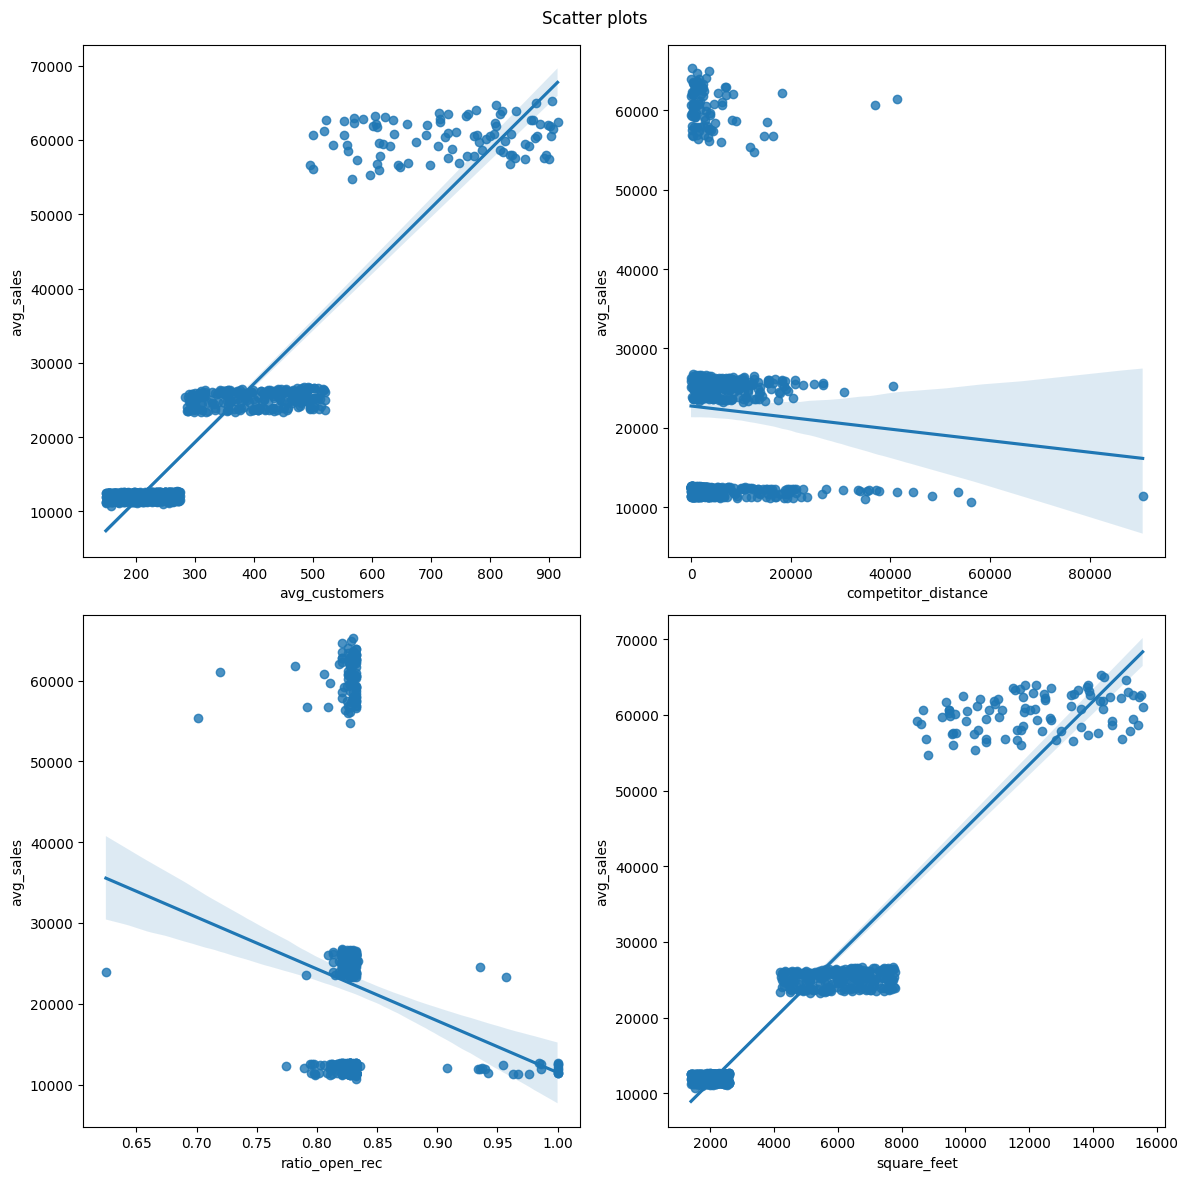

In [38]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=[12,12])
for i,col in enumerate(X.columns.difference(categorical_variables)):
     if i <= 1:
        sns.regplot(x=X[col], y=y, ax=ax[0,i])
     else:
         sns.regplot(x=X[col], y=y, ax=ax[1,i-2])   

fig.suptitle('Scatter plots')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

plt.show()
plt.clf()
plt.close()

We can immediately observe that in each scatter plot observations are grouped in clusters determined by their market type.  
 We can easily see the link between market types and clusters looking at the plot of **square_feet**: the mean of the clusters will be near to the one computed before, during the null value filling for **market_type** [12090 (Hyper), 2010 (Mini), 6054 (Super)].  
For **avg_customers** and **square_feet** there is a clear linear dependence which strengthens their goodness as predictors of **avg_sales**.  
The same dependence is way weaker, hence steeper, for **ratio_open_rec**  and vanishes completely with the **competitor_distance**. For these last two, we can also notice that clusters are no more identified by the x axis

Now we plot the countplots and the barplots of the categorical variables with respect to the target variable, in order to visually understand the influence of different labels of each categorical variable to the **avg_sales** 

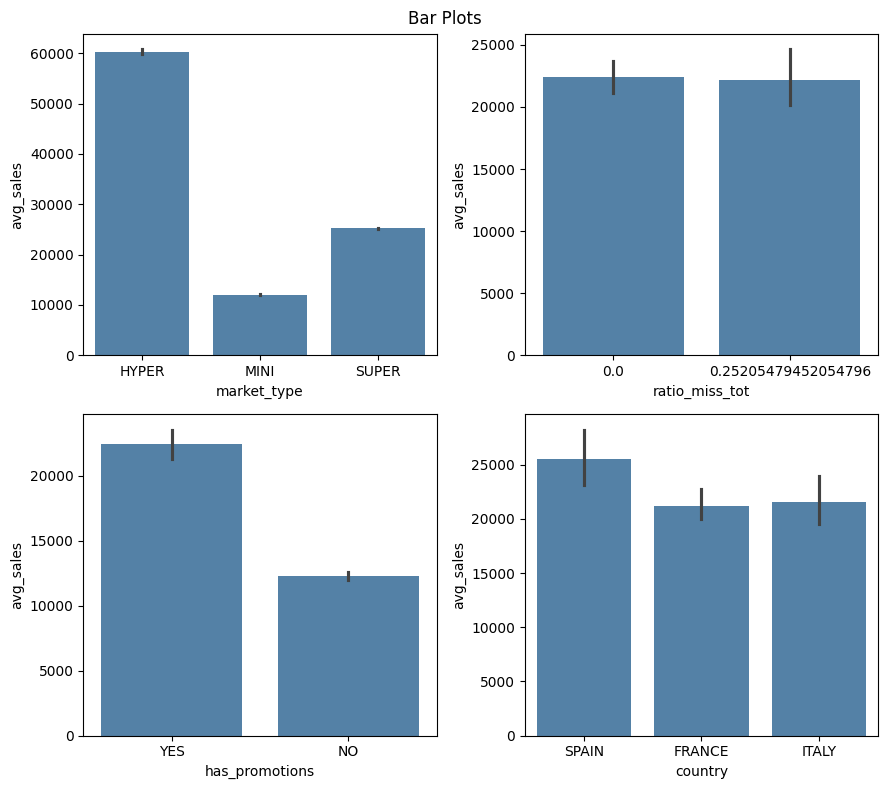

In [39]:
# barcharts
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=[9,8])
for i,col in enumerate(list(set(X.columns) & set(categorical_variables))):
     if i <= 1:
        sns.barplot(x=X[col], y=y, ax=ax[0,i],color='steelblue')
     else:
         sns.barplot(x=X[col], y=y, ax=ax[1,i-2],color='steelblue') 
        
fig.suptitle('Bar Plots')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

plt.show()
plt.clf()
plt.close()

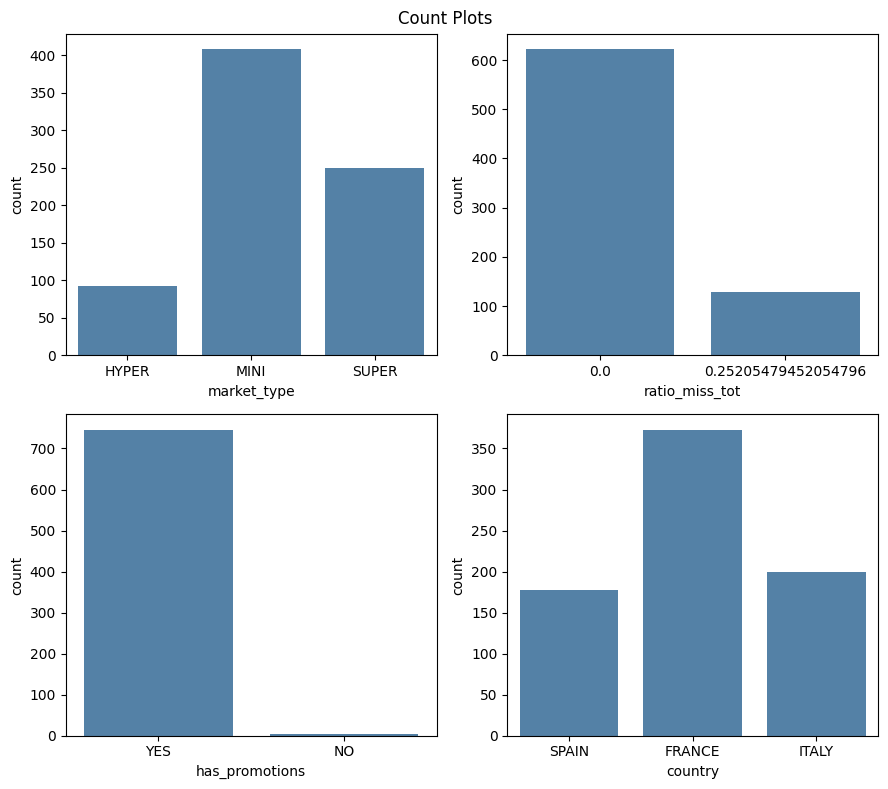

In [40]:
# countplots
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=[9,8])
for i,col in enumerate(list(set(X.columns) & set(categorical_variables))):
     if i <= 1:
        sns.countplot(x=X[col], ax=ax[0,i],color='steelblue')
     else:
         sns.countplot(x=X[col], ax=ax[1,i-2],color='steelblue') 
        
fig.suptitle('Count Plots')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

plt.show()
plt.clf()
plt.close()

We observe that  
- for the variable **country**, there is a small difference in **avg_sales** with respect to different country. In particular Spain has the highest avg_sales, followed by Italy and immediately after France  
- for the variable **ratio_miss_tot**, the **avg_sales** is quite the same for markets with some missing records and the other with full 2 years recorded , so we can already doubt its statistical significance as predictor 
- for the variable **market_type**, as we can expect, there is a big difference in **avg_sales** with respect to different type of market. In particular the highest average sales corresponds to hypermarkets, followed by supermarkets (with an average sales that is less than half of the previous one) and later by minimarkets 
- for the variable **has_promotions**, there is a quite significant difference in **avg_sales** depending on the fact that the market has promotion or not. The ones which offer promotions will obviously have a greater average sales. This feature can partially balance the fact that looking at the countplot, the variable can almost be considered as a constant since only a very small group of markets does not run promotions

Let's check if there are some outliers and analyze them

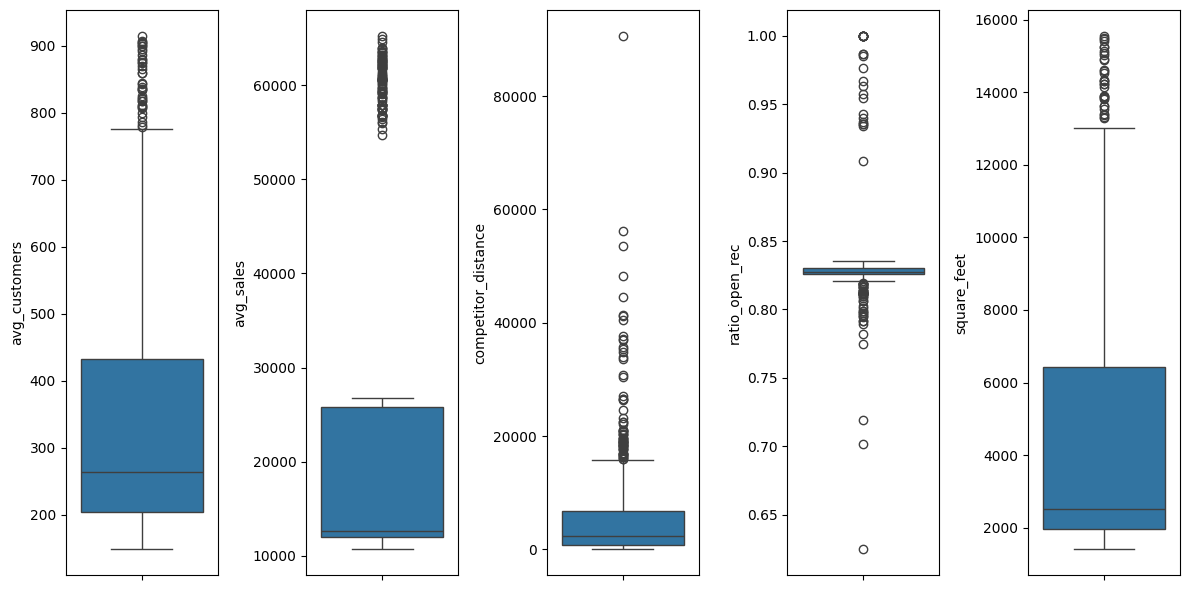

In [41]:
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=[12,6])
index = 0
ax = ax.flatten()
for k, v in merged_df.loc[:,merged_df.columns.difference(categorical_variables)].items():
    sns.boxplot(y=k, data=merged_df, ax=ax[index])
    index += 1
plt.tight_layout()

Here we can see how the number of outliers is quite high for each variable. Looking again at the countplots, this can be seen as reasonable: markets share common features based on the market type, and since two of them, mini and super, together have a way higher frequence than hyper the median and the quantiles will be centered around them, leaving observations of hyper being classified as outliers.  

The standard approach to check outliers is to compute the IQR (interquartile range) and then check values that are 
- lower than quantile(0.25) - 1.5IQR or
- greater than quantile(0.75) + 1.5IQR

In [42]:
for k, v in merged_df.loc[:,merged_df.columns.difference(categorical_variables)].items(): #k is the name of the column, v contains all the values of the column k 
    q1 = v.quantile(0.25) #first quantile
    q3 = v.quantile(0.75) #third quantile
    iqr = q3-q1
    outliers_v = v[(v <= q1 - 1.5*iqr) | (v >= q3 + 1.5*iqr)]
    print(f"The column {k} has {round(len(outliers_v)/len(v) * 100, 2)}%")

The column avg_customers has 5.07%
The column avg_sales has 12.27%
The column competitor_distance has 8.8%
The column ratio_open_rec has 9.33%
The column square_feet has 4.27%


Since we have previously detected a problem due to the higher combined frequency of two groups, we plot again the boxplots but considering only data sharing the same type of market.

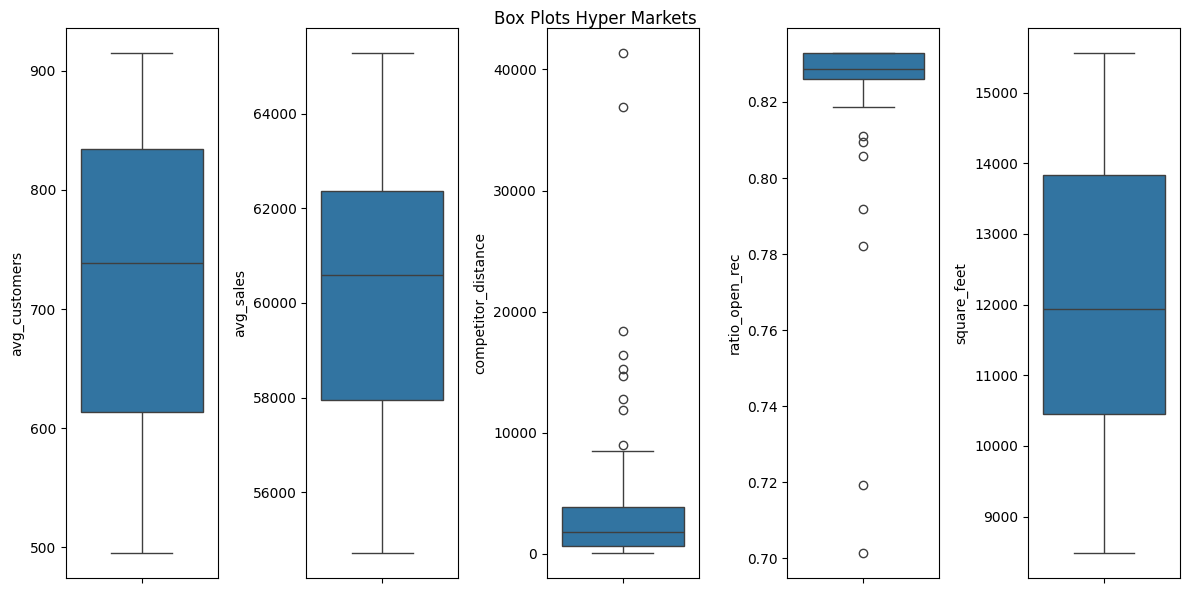

In [43]:
#Boxplots for HYPERmarkets
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=[12,6])
index = 0
ax = ax.flatten()
for k, v in merged_df.loc[:,merged_df.columns.difference(categorical_variables)].items():
    sns.boxplot(y=k, data=merged_df.loc[merged_df['market_type']=='HYPER'], ax=ax[index])
    index += 1

fig.suptitle('Box Plots Hyper Markets')
plt.tight_layout()
fig.subplots_adjust(top=0.95)

plt.show()
plt.clf()
plt.close()

In [44]:
for k, v in merged_df.loc[merged_df['market_type']=='HYPER',merged_df.columns.difference(categorical_variables)].items(): #k is the name of the column, v contains all the values of the column k 
    q1 = v.quantile(0.25)
    q3 = v.quantile(0.75)
    iqr = q3-q1
    outliers_v = v[(v <= q1 - 1.5*iqr) | (v >= q3 + 1.5*iqr)]
    print(f"The column {k} has {round(len(outliers_v)/len(v) * 100, 2)}%")

The column avg_customers has 0.0%
The column avg_sales has 0.0%
The column competitor_distance has 9.78%
The column ratio_open_rec has 7.61%
The column square_feet has 0.0%


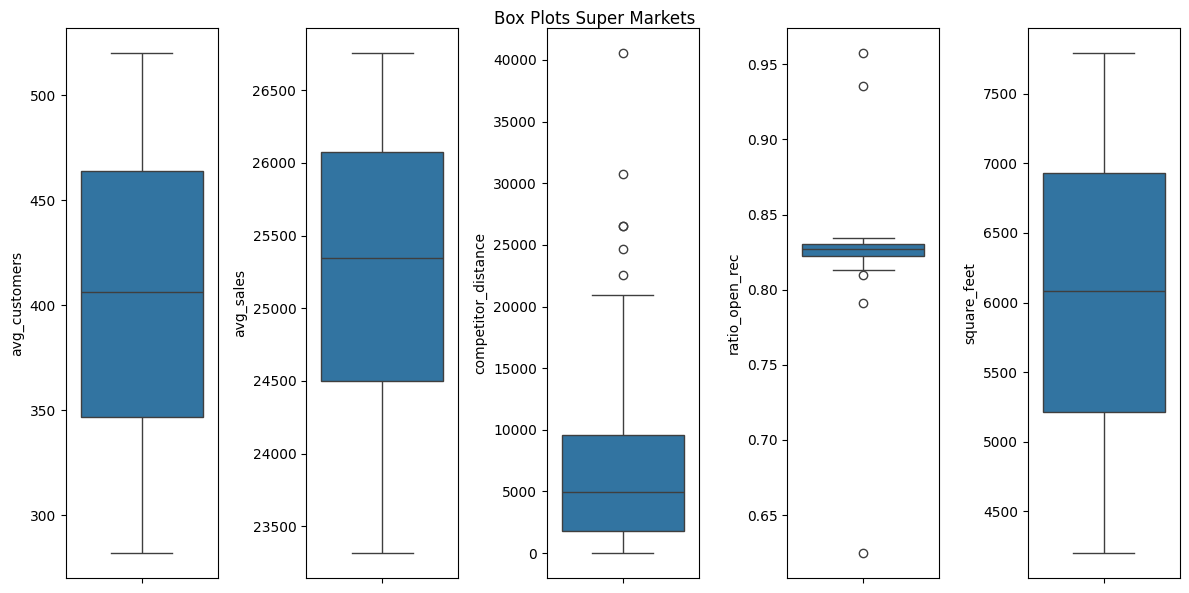

In [45]:
#Boxplots for SUPERmarkets
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=[12,6])
index = 0
ax = ax.flatten()
for k, v in merged_df.loc[:,merged_df.columns.difference(categorical_variables)].items():
    sns.boxplot(y=k, data=merged_df.loc[merged_df['market_type']=='SUPER'], ax=ax[index])
    index += 1

fig.suptitle('Box Plots Super Markets')
plt.tight_layout()
fig.subplots_adjust(top=0.95)

plt.show()
plt.clf()
plt.close()

In [46]:
for k, v in merged_df.loc[merged_df['market_type']=='SUPER',merged_df.columns.difference(categorical_variables)].items(): #k is the name of the column, v contains all the values of the column k 
    q1 = v.quantile(0.25)
    q3 = v.quantile(0.75)
    iqr = q3-q1
    outliers_v = v[(v <= q1 - 1.5*iqr) | (v >= q3 + 1.5*iqr)]
    print(f"The column {k} has {round(len(outliers_v)/len(v) * 100, 2)}%")

The column avg_customers has 0.0%
The column avg_sales has 0.0%
The column competitor_distance has 2.4%
The column ratio_open_rec has 2.0%
The column square_feet has 0.0%


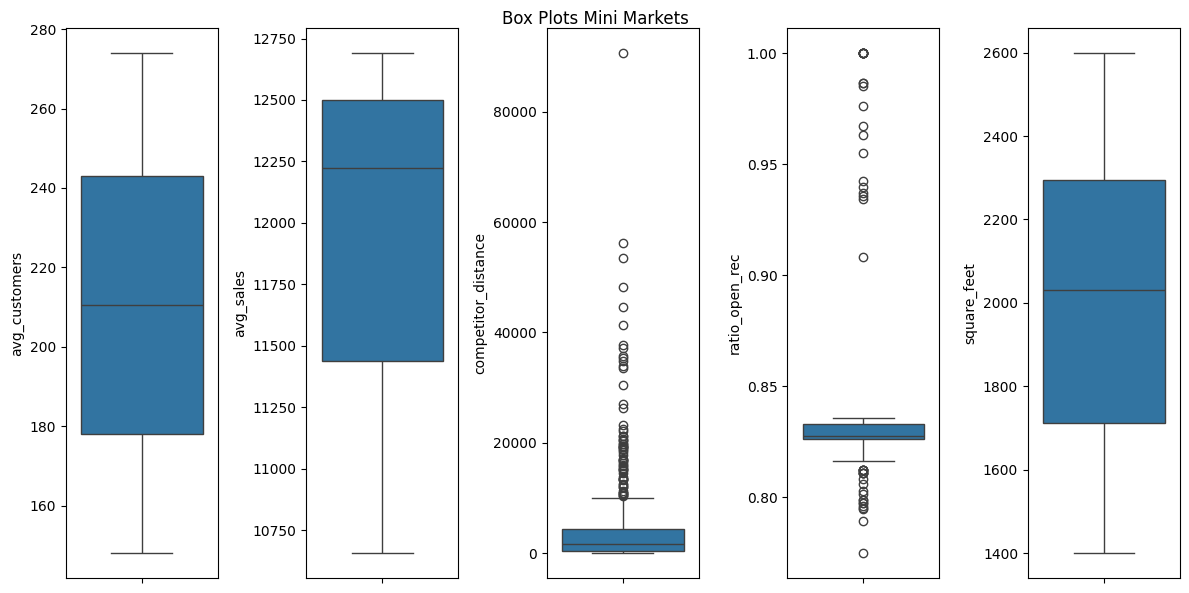

In [47]:
#Boxplots for MINImarkets
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=[12,6])
index = 0
ax = ax.flatten()
for k, v in merged_df.loc[:,merged_df.columns.difference(categorical_variables)].items():
    sns.boxplot(y=k, data=merged_df.loc[merged_df['market_type']=='MINI'], ax=ax[index])
    index += 1

fig.suptitle('Box Plots Mini Markets')
plt.tight_layout()
fig.subplots_adjust(top=0.95)

plt.show()
plt.clf()
plt.close()
#paesini isolati --> motivo per cui hai una grande competitor distance

In [48]:
for k, v in merged_df.loc[merged_df['market_type']=='MINI',merged_df.columns.difference(categorical_variables)].items(): #k is the name of the column, v contains all the values of the column k 
    q1 = v.quantile(0.25)
    q3 = v.quantile(0.75)
    iqr = q3-q1
    outliers_v = v[(v <= q1 - 1.5*iqr) | (v >= q3 + 1.5*iqr)]
    print(f"The column {k} has {round(len(outliers_v)/len(v) * 100, 2)}%")

The column avg_customers has 0.0%
The column avg_sales has 0.0%
The column competitor_distance has 15.2%
The column ratio_open_rec has 10.54%
The column square_feet has 0.0%


For *Hyper* and *Super* markets we observe that the outliers reduced a lot, as expected.      
For *Mini* markets we can see a high amount of outliers for both **competitor_distance** and **ratio_open_rec**. For the first one, this can be heuristically explained by the fact that probably in very small and isolated cities there are only mini markets, hence they will be pretty far from any other market. For the second one, due to them being small local realities, they are more flexibile in their closing days

### Encode Categorical variables

In the dataset `merged_df` there are 5 categorical variables:  
- the variable **id** assumes 750 values, corresponding to the identification number of each market
- the variable **ratio_miss_tot** assumes only 2 values, that are 0 or 0.252055, corresponding respectively to the markets with all days recorded and to the ones with 184 days missing
- the variable **country** assumes only 3 values, that are "ITALY", "SPAIN", "FRANCE"
- the variable **market_type** assumes only 3 values, that are "MINI", "SUPER", "HYPER"
- the variable **has_promotions** is a binary variable, assuming only "YES" or "NO"


We encode these variables because otherwise we cannot use as valid predictors them in the linear regression. Now we map the labels into integers, and later we will express the non binary variables introducing new dummys.

In [49]:
#ratio_miss_tot
merged_df['ratio_miss_tot'] = merged_df['ratio_miss_tot'].map({list(set(merged_df['ratio_miss_tot']))[0]: 0, list(set(merged_df['ratio_miss_tot']))[1]: 1})
#country
merged_df['country'] = merged_df['country'].map({'ITALY': 0, 'SPAIN': 1, 'FRANCE': 2})
#market_type
merged_df['market_type'] = merged_df['market_type'].map({'MINI': 0, 'SUPER': 1, 'HYPER': 2})
#has_promotions
merged_df['has_promotions'] = merged_df['has_promotions'].map({'NO': 0, 'YES': 1})

In [50]:
merged_df

,id,ratio_open_rec,avg_sales,ratio_miss_tot,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
0,XC14,0.830137,60598.0,0,1,2,11135,773.0,515,1
1,WG25,0.832877,12509.0,0,2,0,1402,252.0,522,1
2,UX72,0.827397,12329.0,0,2,0,1452,265.0,15939,1
3,EE84,0.832877,62629.0,0,1,2,15259,874.0,754,1
4,RF54,0.826027,12086.0,0,2,0,2497,191.0,34007,1
...,...,...,...,...,...,...,...,...,...,...
745,ZM74,0.830137,23583.0,0,0,1,5778,356.0,4424,1
746,WW60,0.828767,61447.0,0,2,2,10923,907.0,41359,1
747,LU14,0.827397,23704.0,0,0,1,5742,397.0,2841,1
748,HY57,0.827397,11417.0,0,0,0,2495,228.0,3848,1


### Fit a Linear model

We want to predict **avg_sales** using all the other variables  
In order to do so, we need to create other additional dummy variables substituting the variables **country** and **market_type**:  
- **country_F** assuming value 1 if the market is in France, 0 othherwise
- **country_S** assuming value 1 if the market is in Spain, 0 othherwise
- **market_S** assuming value 1 if the market is a supermarket, 0 otherwise
- **market_H** assuming value 1 if the market is a hypermarket, 0 otherwise

In [51]:
country_F=[0]*len(merged_df) #France
country_S=[0]*len(merged_df) #Spain
market_S=[0]*len(merged_df) #Supermarket
market_H=[0]*len(merged_df) #Hypermarket
for i in range(len(merged_df)) :
    if merged_df.loc[i, 'country'] == 1 : #spain
        country_S[i]=1
    elif merged_df.loc[i, 'country'] == 2 : #france
        country_F[i]=1
    if merged_df.loc[i, 'market_type'] == 1 : #supermarket
        market_S[i]=1
    elif merged_df.loc[i, 'market_type'] == 2 : #hypermarket
        market_H[i]=1

The new dummy variables we have just created substitute the "old" variables **country** and **market_type**

In [52]:
X = merged_df.loc[:,merged_df.columns.difference(['avg_sales', 'id'])]
obsolete_predictors=['country','market_type']
X.drop(obsolete_predictors,axis='columns', inplace=True)
X = X.join(pd.DataFrame(
    {
        'Country_F': country_F,
        'Country_S': country_S,
        'market_S': market_S,
        'market_H': market_H,
    }, index=X.index
))


Now we are ready to fit the linear model, using OLS

In [53]:
#Fitting the model

X_train,X_test, y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=55)
X_train_with_c=sm.add_constant(X_train)
X_test_with_c=sm.add_constant(X_test)

model=sm.OLS(y_train,X_train_with_c).fit()

y_pred=model.predict(X_test_with_c)
beta=round(model.params,3)


After the fitting, we print the coefficients of our model with

In [54]:
#SE
se=round(model.bse,3)
#t-statistics
t=round(model.tvalues,3)
#p-values
p_val=round(model.pvalues,5)

beta_names=['beta_%s' % i for i in X_test_with_c.columns]
coeff_sum=pd.DataFrame({'Betas':beta_names,'Estimated values':beta,'Standard Errors':se,'t-statistic':t,'p-values':p_val}).reset_index(drop=True)
coeff_sum

,Betas,Estimated values,Standard Errors,t-statistic,p-values
0,beta_const,8104.583,910.428,8.902,0.00000
1,beta_avg_customers,3.306,0.403,8.208,0.00000
2,beta_competitor_distance,-0.020,0.003,-6.269,0.00000
3,beta_has_promotions,196.329,441.651,0.445,0.65682
4,beta_ratio_miss_tot,51.122,69.222,0.739,0.46050
5,beta_ratio_open_rec,1636.224,955.219,1.713,0.08725
6,beta_square_feet,0.264,0.027,9.798,0.00000
7,beta_Country_F,2008.448,60.550,33.170,0.00000
8,beta_Country_S,1051.856,72.483,14.512,0.00000
9,beta_market_S,11473.015,143.502,79.950,0.00000


In [55]:
non_stat_rel=coeff_sum[coeff_sum['p-values']>0.005] 
print(f'{list(non_stat_rel.iloc[:,0])} are not statistical significant coefficients with level 0.95 since their p-value is greater than 0.001')

['beta_has_promotions', 'beta_ratio_miss_tot', 'beta_ratio_open_rec'] are not statistical significant coefficients with level 0.95 since their p-value is greater than 0.001


The delta changes between target and predictors are the following:  
- a 1-unit increase in **avg_customers** leads to an increase of 3.306€ of average daily sales and it is statistical significant.
- a 1-unit increase in **competitor_distance** has almost no effect on the target variable leading to a decrease of  0.02€ of average daily sales and it is statistical significant.
- the difference between the markets with the variable **has_promotions** equal to 1 (i.e. the market runs promotions) and the ones with no promotions amounts for average sales to 196.329€. However, because of a very high p-value, this variable is not statical significant.
- a 1-unit increase in **ratio_miss_tot** will produce an increase of 51.122€. On average the markets for which we have full recordings show higher sales. However, it is not statistical significant.
- a 1-unit increase in **ratio_open_rec** will generate an increase of 1636.224€. On average the markets with a higher number of opening days on percentage will sell more. However, it is not so significant because its p-value is greater than 0.05
- a 1-unit increase in **square_feet** has a near-zero effect to the target variable. It is statistical significant.
- the difference in average sales between the markets with the variable **country_F** equal to 1 (i.e. the markets in France) and the ones in Italy is equal to 2008.448€. It is statistical significant.
- the difference in average sales between the markets with the variable **country_S** equal to 1 (i.e. the markets in Spain) and the ones in Italy is equal to 1051.856€. It is statistical significant.
- the difference in average sales between the markets with the variable **market_S** equal to 1 (i.e. the markets is a Supermarket) and the Minimarkets is equal to 11473.015€. It is statistical significant.
- the difference in average sales between the markets with the variable **market_S** equal to 1 (i.e. the markets is a Supermarket) and the Minimarkets is equal to 44139.429€. It is statistical significant.


Here we compute some indexes to verify the quality of the regression
- **RSE**
- **R<sup>2</sup>**
- **MSE**

In [56]:
#RSE
residuals = y_pred-y_test
rse = ((residuals**2).sum()/(len(residuals)-X.shape[1]-1))**0.5
#R2
r2 = 1-(residuals**2).sum()/((y_test-y_test.mean())**2).sum()
#MSE
mse = (residuals**2).mean()
print(f'The RSE is {round(rse,2)}, the R2 is {round(r2,5)} and the MSE is {round(mse,2)} ')

The RSE is 672.61, the R2 is 0.99818 and the MSE is 419222.25 


The R<sup>2</sup> is extremely high, being nearly equal to 1, symptom that all our data lie on the same hyperplane and the relationship between target variable and predictors is almost perfectly linear.   
Looking instead at the MSE, we can state it is quite high too, which combined to also a R<sup>2</sup> very high, implies a high probability of over fittting.

The potential problems of linear regression could be:
- Correlation of error terms  
- Non-constant variance of error terms  
- Outliers  
- Collinearity  
  
Except of outliers that we have already checked before, let's analyze the remaining problems

As regards *correlation of the error term*, we plot the residuals from our model and check if there is any discernible pattern

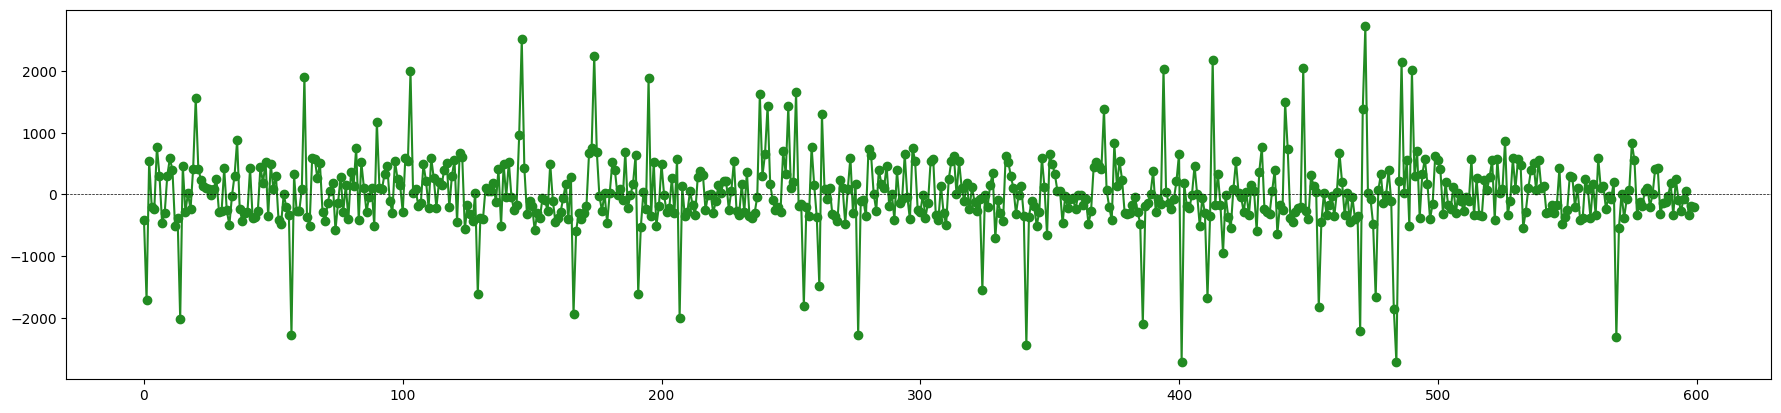

In [ ]:
# Autocorrelation plot 
residuals_training = model.resid
plt.figure().set_figwidth(22)
plt.plot(range(len(residuals_training)),residuals_training,marker='o',color='forestgreen')
plt.axhline(y=0,  linestyle='dashed',color='black',linewidth=0.5)
plt.show()

Looking at the chart, we cannot clearly see some patterns among the errors, so it seems there is no correlation among error terms.  
To quantify the correlation there are multiple options:
- compute the *autocorrelation with lagged-1 residuals*: this returns a number from 0 to 1, the closer to 0 the stronger is the non-correlation
- compute *Durbin-Watson*: this returns a number from 0 to 4, the closer to 2 the stronger is the non-correlation

In [58]:
# autocorrelation
lagged_residuals = residuals_training.shift(1)  # Lagged residuals
autocorrelation = (residuals_training.corr(lagged_residuals)) ** 2

# durbin_watson
durbin_watson = sm.stats.durbin_watson(residuals_training)

print(f"The autocorrelation is {round(autocorrelation, 5)} while the durbing watson statistic is {round(durbin_watson, 5)}, suggesting that error terms are not correlated")

The autocorrelation is 0.00859 while the durbing watson statistic is 1.81378, suggesting that error terms are not correlated


As regards *heteroskedasticity*, we plot the fitted values versus the residuals

Text(0, 0.5, 'Residuals')

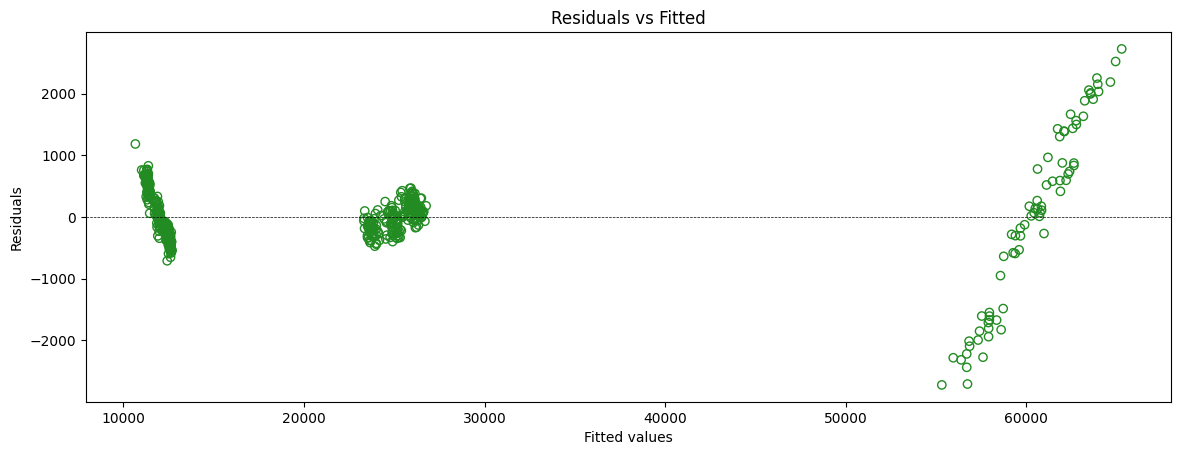

In [59]:
# heteroskedasticty plot 
plt.figure().set_figwidth(14)
plt.scatter(y_train,residuals_training,facecolors='none', edgecolors='forestgreen')
plt.axhline(y=0,  linestyle='dashed',color='black',linewidth=0.5)
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')

plt.ylabel('Residuals')

From the plot, we deduce that data are affected by heteroskedasticity, since variance is not constant but it increases with increasing fitted values. However, we also notice the variance can be considered homogeneous inside each cluster.

To test heteroskedasticity in a more formal way, we use the *Breusch-Pagan test*

In [60]:
# Braush Pagan test
name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test=statsmodels.stats.diagnostic.het_breuschpagan(resid=model.resid,exog_het=model.model.exog)
lzip(name,test)

[('Lagrange multiplier statistic', 331.7360515988793),
 ('p-value', 2.9771948893185877e-65),
 ('f-value', 72.83592728590571),
 ('f p-value', 3.405591208064267e-96)]

Both p-values are under 0.05, which means there is not statistical evidence to accept the null hypothesis (i.e. homoskedasticity). Therefore, as expected by the plot, we have an further indicator of heteroskedasticity.  
In order to solve this problem, we apply a *log-transformation* to the target variable, and we repeat analogous steps as before.

In [61]:
#Change our y to log y 
y_log=np.log(y)

#Fitting the model again
X_train,X_test, y_log_train,y_log_test=train_test_split(X,y_log,test_size=0.2,random_state=55)
X_train_with_c=sm.add_constant(X_train)
X_test_with_c=sm.add_constant(X_test)

model=sm.OLS(y_log_train,X_train_with_c).fit()

y_log_pred=model.predict(X_test_with_c)
beta=round(model.params,3)


Text(0, 0.5, 'Residuals')

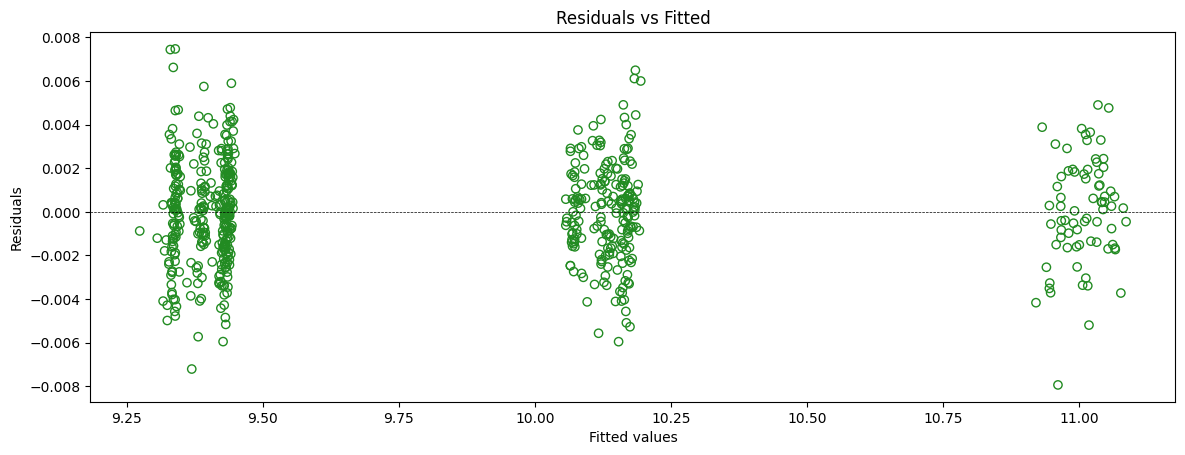

In [62]:
#Computing the residuals

#HETEROSKEDASTICITY PLOT
plt.figure().set_figwidth(14)
plt.scatter(y_log_train,model.resid,facecolors='none', edgecolors='forestgreen')
plt.axhline(y=0,  linestyle='dashed',color='black',linewidth=0.5)
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

In this case the variance is visibly lower and independent of the fitted values. 

In [63]:
# Brausch Pagan test
name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test=statsmodels.stats.diagnostic.het_breuschpagan(resid=model.resid,exog_het=model.model.exog)
lzip(name,test)

[('Lagrange multiplier statistic', 7.812605178886289),
 ('p-value', 0.6471355264474141),
 ('f-value', 0.777055454169884),
 ('f p-value', 0.6510942094696309)]

Unlike before, here both the p-values are greater than 0.05, hence there is statistical evidence for accepting the null hypothesis.  
So applying a log-transformation to the target variable we have solved the problem of heteroskedasticity.

In [64]:
#RSE
residuals=y_log_pred-y_log_test
rse=((residuals**2).sum()/(len(residuals)-X.shape[1]-1))**0.5
#R2
r2=1-(residuals**2).sum()/((y_test-y_test.mean())**2).sum()
#MSE
mse=(residuals**2).mean()
print(f'The RSE is {round(rse,2)}, the R2 is {round(r2,12)} and the MSE is {round(mse,7)} ')

The RSE is 0.0, the R2 is 1.0 and the MSE is 6.2e-06 


After having printed the accuracy indices we explain here the reason why even if the data are homoskedatic we do not apply the log-transformation later on. The log function strecthes our values for the target variables too much, causing a too big loss of information. The excessive agressiveness of this approach can be also seen in the indicators: the R<sup>2</sup> is perfectly near to 1 instead the MSE is infintesimal

As regards *collinearity*, the most robust approach to check it is to use the **Variance Inflation Factor** (VIF) for each of the coefficient estimates.

In [65]:
vif = pd.DataFrame()
vif["Predictor"] = X.columns
vif["VIF Factor"] = [statsmodels.stats.outliers_influence.variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif.round(2)

,Predictor,VIF Factor
0,avg_customers,35.26
1,competitor_distance,1.48
2,has_promotions,159.90
3,ratio_miss_tot,1.26
4,ratio_open_rec,172.74
5,square_feet,36.62
6,Country_F,2.89
7,Country_S,1.92
8,market_S,10.65
9,market_H,23.10


Since, as a rule of thumb, a VIF value that exceeds 5 or 10 indicates a problematic amount of collinearity, the following variables can create potential problems.

In [66]:
coll_pred=vif[vif['VIF Factor']>10]['Predictor']
print(f'{list(coll_pred)} shows high multicollinearity problem since the VIF factor associated is larger than 10')

['avg_customers', 'has_promotions', 'ratio_open_rec', 'square_feet', 'market_S', 'market_H'] shows high multicollinearity problem since the VIF factor associated is larger than 10


#### Best Subset Selection

We apply *Best Subset Selection*, that is one big family of *Feature Selection*, in order to exclude from the set of predictors the ones which are irrelevant and lead to unnecessary complexity of the model.  
In addition, since the procedure used in OLS can be easily affected by a lucky/unlucky split between training and test data, we introduce *K-Fold* to guarantee a more consistent result.

In [67]:
#Step 0: Define a variable of interest and a set of predictors

# Step 1: initialize KFold object to use for model evaluation
number_folds = 5
kf = KFold(n_splits=number_folds, shuffle=True, random_state=55)

# Step 2: Define a function to calculate RSE, R2, and MSE
def calculate_metrics(y_validation, y_pred, X):
    residuals = y_validation - y_pred
    RSE = (sum(residuals ** 2) / (len(residuals) - X.shape[1] - 1)) ** 0.5
    R2 = 1 - (residuals ** 2).sum() / ((y_validation - y_validation.mean()) ** 2).sum()
    MSE = (residuals ** 2).mean()
    return RSE, R2, MSE

# Step 3: Implement best subset selection
def best_subset_selection(X, y, target_col):
    n_features = X.shape[1]
    all_models = []
    best_models = []
    best_metrics = {
        'y_pred':list,
        'y_val':list,
        'y_train': list,
        'residuals': list,
        'params': pd.DataFrame,
        'exog':list,
        "RSE": float("inf"),
        "R2": -float("inf"),
        "MSE": float("inf"),
    }

    # for each number of features
    for k in range(1, n_features + 1):
        print(f"start iteration {k} of {n_features}")
        # for each combination of k number of features
        for combo in itertools.combinations(X.columns, k):
            model_features = list(combo)
            X_subset = X[model_features]
            # Add a constant for the intercept term
            X_subset = sm.add_constant(X_subset)  
            # initialize empty array to store mse for each fold
            mse_folds = 0
            rse_folds = 0
            # for each fold fit the model
            for train_idx, validation_idx in kf.split(X_subset):
                X_train, X_validation = X_subset.iloc[train_idx], X_subset.iloc[validation_idx]
                y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]
                model = sm.OLS(y_train, X_train).fit()
                resid=model.resid
                y_pred = model.predict(X_validation)
                RSE, R2, MSE = calculate_metrics(y_validation, y_pred, X[model_features])
                mse_folds = mse_folds + MSE
                rse_folds= rse_folds + RSE
            # estimate test error using the mean of MSE in all folds
            test_error_estimated = mse_folds / number_folds
            train_error_estimated = rse_folds / number_folds
            # if the estimation of the test error is reduced, save metrics and model
            if test_error_estimated < best_metrics["MSE"]:
                best_metrics['params']=model.params
                best_metrics['exog']=model.model.exog
                best_metrics['y_train']=y_train
                best_metrics['y_pred']=y_pred
                best_metrics['y_val']=y_validation
                best_metrics["residuals"]=resid
                best_metrics["RSE"] = RSE
                best_metrics["R2"] = R2
                best_metrics["MSE"] = test_error_estimated
                best_models = model_features
            # save number of features and estimated test error for plotting
            all_models.append([len(list(combo)), test_error_estimated, train_error_estimated])

    return best_models, best_metrics, all_models

# Step 4: Calculate and display statistics for each model
best_features, best_metrics, all_models = best_subset_selection(X, y, 'avg_sales')

print("-------------------")
print("Finished!")
print("Features with best model:", best_features)
print(f"The feature deleted is {list(X.columns.difference(best_features))}")
print("RSE:", best_metrics["RSE"])
print("R2:", best_metrics["R2"])
print("MSE:", best_metrics["MSE"])

start iteration 1 of 10
start iteration 2 of 10
start iteration 3 of 10
start iteration 4 of 10


start iteration 5 of 10
start iteration 6 of 10
start iteration 7 of 10
start iteration 8 of 10
start iteration 9 of 10
start iteration 10 of 10
-------------------
Finished!
Features with best model: ['avg_customers', 'competitor_distance', 'has_promotions', 'square_feet', 'Country_F', 'Country_S', 'market_S', 'market_H']
The feature deleted is ['ratio_miss_tot', 'ratio_open_rec']
RSE: 671.663839986797
R2: 0.9980567320642268
MSE: 397928.45698958746


Let's look at results:
1) The MSE has decreased from 419222.25 to 397928.45. This implies what we previously did was overestimating the errors. 
2) The model performing the best has only 8 predictors instead of 10. The best features have been printed above

Let's now plot all models to see how the MSE curve decreases

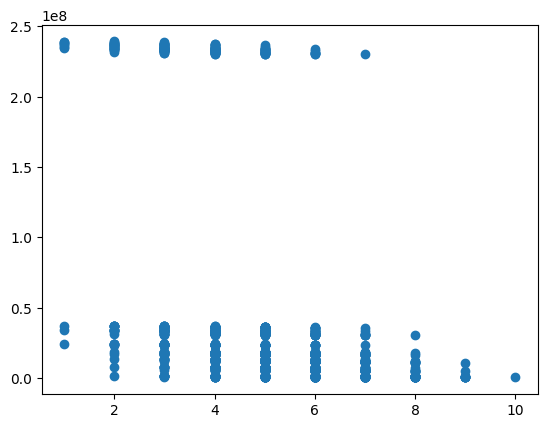

In [68]:
fig, ax = plt.subplots(ncols=1, nrows=1)
plt.scatter([elem[0] for elem in all_models], [elem[1] for elem in all_models])

When k > 8 the estimated MSE test error remains quite consistent


For the next steps, due to the difference scales of our predictors, it is useful to standardize the data.

In [69]:
# filter data based on best_features
X_subset = X[best_features]

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_subset)
X_scaled = pd.DataFrame(X_scaled, columns=X_subset.columns)
# check if features have been standardized
for col in X_scaled.columns:
    print(f"The column {col} has mean {round(X_scaled[col].mean(), 2)} and variance {round(X_scaled[col].var(), 2)}")

The column avg_customers has mean 0.0 and variance 1.0
The column competitor_distance has mean -0.0 and variance 1.0
The column has_promotions has mean -0.0 and variance 1.0
The column square_feet has mean 0.0 and variance 1.0
The column Country_F has mean -0.0 and variance 1.0
The column Country_S has mean 0.0 and variance 1.0
The column market_S has mean 0.0 and variance 1.0
The column market_H has mean -0.0 and variance 1.0


#### Shrinkage Methods

Then we proceed with the shrinkage methods:
- **Ridge**
- **Lasso**

For the Ridge we have

Text(0, 397968.2498352864, 'Best OLS estimation')

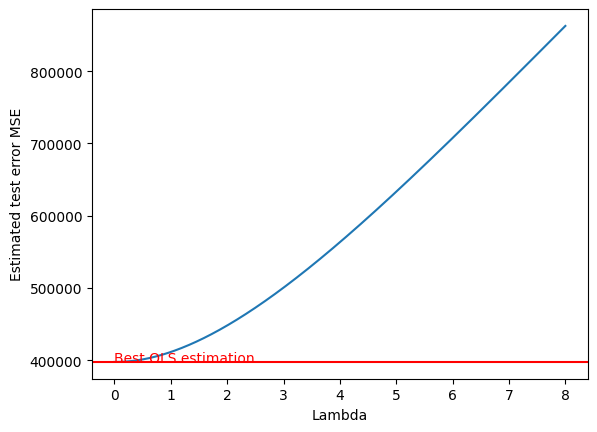

In [70]:
# Ridge

# save test error and lambda values
results_ridge = []
best_lmbd_ridge = {"MSE": float("inf"), "lmbd": float("inf")}

# iterate over different values of lambda
for lmbd in np.linspace(0.0001, 8, 1000):
    # initialize empty array to store mse for each fold
    mse_folds = []
    # for each fold fit the model
    for train_idx, validation_idx in kf.split(X_scaled):
        X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
        y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]
        model = Ridge(alpha=lmbd).fit(X_train, y_train)
        y_pred = model.predict(X_validation)
        RSE, R2, MSE = calculate_metrics(y_validation, y_pred, X_subset)
        mse_folds.append(MSE)
    # estimate test error using the mean of MSE in all folds
    test_error_estimated = sum(mse_folds) / len(mse_folds)
    # append
    results_ridge.append([test_error_estimated, lmbd])
    # check if model improved
    if test_error_estimated < best_lmbd_ridge["MSE"]:
        best_lmbd_ridge["MSE"] = test_error_estimated
        best_lmbd_ridge["lmbd"] = lmbd

# plot estimated test MSE for each value of lambda
fig, ax = plt.subplots(ncols=1, nrows=1)
plt.plot([elem[1] for elem in results_ridge], [elem[0] for elem in results_ridge])
plt.xlabel("Lambda")
plt.ylabel("Estimated test error MSE")
plt.axhline(best_metrics["MSE"], color="red")
plt.text(0, best_metrics["MSE"] * 1.0001, "Best OLS estimation", color="red") # * 1.0001 is used to place the text a bit above best_metrics["MSE"]

In [71]:
# compare min using Ridge and OLS
min_ridge_test_error_estimated = min([elem[0] for elem in results_ridge])

print(f"Using OLS, the best model has an estimated test MSE of {round(best_metrics['MSE'], 2)}")
print(f"Using Ridge, the best model has an estimated test MSE of {round(min_ridge_test_error_estimated, 2)} using a value of lambda = {round(best_lmbd_ridge['lmbd'], 2)}")

Using OLS, the best model has an estimated test MSE of 397928.46
Using Ridge, the best model has an estimated test MSE of 397917.52 using a value of lambda = 0.02


For the Lasso instead

Text(0, 397957.3102205193, 'Best Ridge estimation')

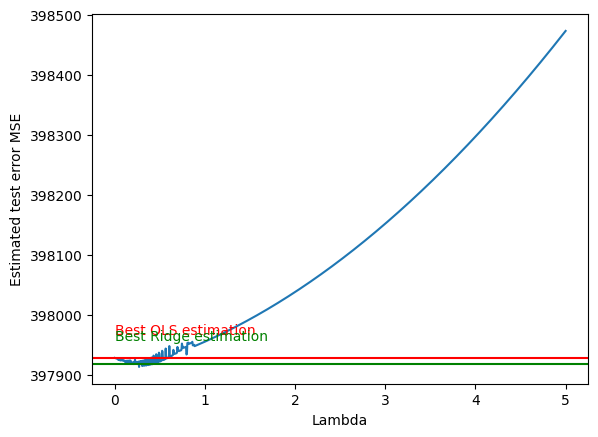

In [72]:
# Lasso

# save test error and lambda values
results_lasso = []
best_lmbd_lasso = {"MSE": float("inf"), "lmbd": float("inf"),'params':pd.DataFrame}

# iterate over different values of lambda
for lmbd in np.linspace(0.0001, 5, 1000):
    # initialize empty array to store mse for each fold
    mse_folds = []
    # for each fold fit the model
    for train_idx, validation_idx in kf.split(X_scaled):
        X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
        y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]
        model = Lasso(alpha=lmbd).fit(X_train, y_train)
        params=model.sparse_coef_
        y_pred = model.predict(X_validation)
        RSE, R2, MSE = calculate_metrics(y_validation, y_pred, X_subset)
        mse_folds.append(MSE)
    # estimate test error using the mean of MSE in all folds
    test_error_estimated = sum(mse_folds) / len(mse_folds)
    # append
    results_lasso.append([test_error_estimated, lmbd])
    # check if model improved
    if test_error_estimated < best_lmbd_lasso["MSE"]:
        best_lmbd_lasso["MSE"] = test_error_estimated
        best_lmbd_lasso["lmbd"] = lmbd
        best_lmbd_lasso['params']=params

# plot estimated test MSE for each value of lambda
fig, ax = plt.subplots(ncols=1, nrows=1)
plt.plot([elem[1] for elem in results_lasso], [elem[0] for elem in results_lasso])
plt.xlabel("Lambda")
plt.ylabel("Estimated test error MSE")
plt.axhline(best_metrics["MSE"], color="red")
plt.text(0, best_metrics["MSE"] * 1.0001, "Best OLS estimation", color="red") 
plt.axhline(min_ridge_test_error_estimated, color="green")
plt.text(0, min_ridge_test_error_estimated * 1.0001, "Best Ridge estimation", color="green") 

In [73]:
# compare min using Lasso, Ridge and OLS
min_lasso_test_error_estimated = min([elem[0] for elem in results_lasso])

print(f"Using OLS, the best model has an estimated test MSE of {round(best_metrics['MSE'], 2)}")
print(f"Using Ridge, the best model has an estimated test MSE of {round(min_ridge_test_error_estimated, 2)} using a value of lambda = {round(best_lmbd_ridge['lmbd'], 2)}")
print(f"Using Lasso, the best model has an estimated test MSE of {round(min_lasso_test_error_estimated, 2)} using a value of lambda = {round(best_lmbd_lasso['lmbd'], 2)}")

Using OLS, the best model has an estimated test MSE of 397928.46
Using Ridge, the best model has an estimated test MSE of 397917.52 using a value of lambda = 0.02
Using Lasso, the best model has an estimated test MSE of 397913.4 using a value of lambda = 0.27


#### Dimension Reduction Methods

 To see if our prediction can be improved by using linear combinations of the original variables, we apply the following dimension reduction methods:
 - **Principal Component Analysis (PCA)** 
 - **Partial Least Square (PLS)**

Text(1, 405875.8688380459, 'Best estimation so far (Ridge)')

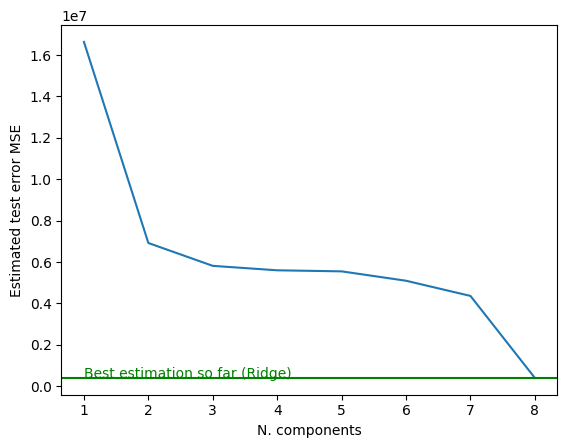

In [74]:
# PCA

# save test error and n_components
results_pca = []
best_components_pca = {"MSE": float("inf"), "n_components": float("inf")}

# iterate over different values of lambda
for n_components in range(1, len(X_scaled.columns) + 1):
    # transform using n_components for PCA
    pca = PCA(n_components = n_components)
    X_pca = pca.fit_transform(X_scaled)
    X_pca = pd.DataFrame(X_pca)
    
    # Add a constant for the intercept term
    X_pca = sm.add_constant(X_pca)  
    # initialize empty array to store mse for each fold
    mse_folds = []
    # for each fold fit the model
    for train_idx, validation_idx in kf.split(X_pca):
        X_train, X_validation = X_pca.iloc[train_idx], X_pca.iloc[validation_idx]
        y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]
        model = sm.OLS(y_train, X_train).fit()
        y_pred = model.predict(X_validation)
        RSE, R2, MSE = calculate_metrics(y_validation, y_pred, X_subset)
        mse_folds.append(MSE)
    # estimate test error using the mean of MSE in all folds
    test_error_estimated = sum(mse_folds) / len(mse_folds)
    # append
    results_pca.append([test_error_estimated, n_components])
    # check if model improved
    if test_error_estimated < best_components_pca["MSE"]:
        best_components_pca["MSE"] = test_error_estimated
        best_components_pca["n_components"] = n_components

# plot estimated test MSE for each value of lambda
fig, ax = plt.subplots(ncols=1, nrows=1)
plt.plot([elem[1] for elem in results_pca], [elem[0] for elem in results_pca])
plt.xlabel("N. components")
plt.ylabel("Estimated test error MSE")
plt.axhline(min_ridge_test_error_estimated, color="green")
plt.text(1, min_ridge_test_error_estimated * 1.02, "Best estimation so far (Ridge)", color="green") 

In [75]:
# compare min using Lasso, Ridge and OLS
min_pca_test_error_estimated = min([elem[0] for elem in results_lasso])

print(f"Using PCA, the best model has an estimated test MSE of {round(min_pca_test_error_estimated, 2)} using a number of components = {round(best_components_pca['n_components'], 2)}")

Using PCA, the best model has an estimated test MSE of 397913.4 using a number of components = 8


Text(1, 405875.8688380459, 'Best estimation so far')

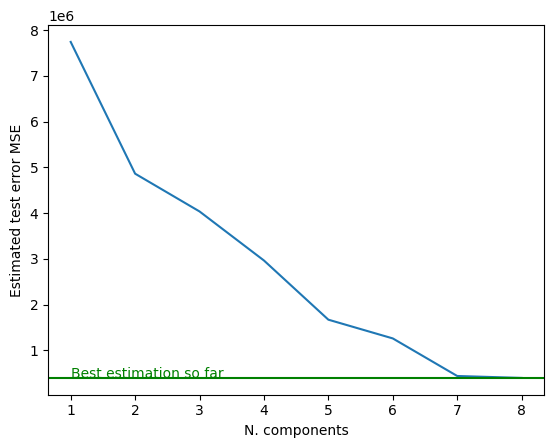

In [76]:
# PLS

# save test error and n_components
results_pls = []
best_components_pls = {"MSE": float("inf"), "n_components": float("inf")}

# iterate over different values of lambda
for n_components in range(1, len(X_scaled.columns) + 1):
    # transform using n_components for PLS
    pls = PLSRegression(n_components = n_components)

    # Note that for PLS the syntax is a bit different from the previous models
    
    # initialize empty array to store mse for each fold
    mse_folds = []
    # for each fold fit the model
    for train_idx, validation_idx in kf.split(X_scaled):
        X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
        y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]
        pls.fit(X_train, y_train)
        y_pred = pls.predict(X_validation)
        y_pred = pd.Series([elem[0] for elem in y_pred])
        RSE, R2, MSE = calculate_metrics(y_validation.reset_index(drop=True), y_pred, X_subset) 
        mse_folds.append(MSE)
    # estimate test error using the mean of MSE in all folds
    test_error_estimated = sum(mse_folds) / len(mse_folds)
    # append
    results_pls.append([test_error_estimated, n_components])
    # check if model improved
    if test_error_estimated < best_components_pls["MSE"]:
        best_components_pls["MSE"] = test_error_estimated
        best_components_pls["n_components"] = n_components

# plot estimated test MSE for each value of lambda
fig, ax = plt.subplots(ncols=1, nrows=1)
plt.plot([elem[1] for elem in results_pls], [elem[0] for elem in results_pls])
plt.xlabel("N. components")
plt.ylabel("Estimated test error MSE")
plt.axhline(min_ridge_test_error_estimated, color="green")
plt.text(1, min_ridge_test_error_estimated * 1.02, "Best estimation so far", color="green") 

In [77]:
# compare min using Lasso, Ridge and OLS
min_pls_test_error_estimated = min([elem[0] for elem in results_pls])

print(f"Using PLS, the best model has an estimated test MSE of {round(min_pls_test_error_estimated, 2)} using a number of components = {round(best_components_pls['n_components'], 2)}")

Using PLS, the best model has an estimated test MSE of 397928.46 using a number of components = 8


In [78]:
print(f"After fitting all models, the most accurate estimated test MSE is obtained by Lasso regression with a value of {round(min_lasso_test_error_estimated, 2)} (reached when lambda = {round(best_lmbd_lasso['lmbd'], 2)})")

After fitting all models, the most accurate estimated test MSE is obtained by Lasso regression with a value of 397913.4 (reached when lambda = 0.27)


## Objective 2

Suppose now that the company is interested in opening 3 new markets: 1 MINI, 1 SUPER and 1 HYPER.
Starting from the latest dataset generated in the previous point, we test all the models that we studied throughout the course.  
Then we pick the best model and apply it to the options to select the most profitable market per each type.  
In particular, we are going to test the following models:  
- Polynomial regression  
- Generalized Additive Model
- Decision trees
- Random forest
- Gradient boosting
- Support vector machine  
- Neural networks

In [80]:
# Creating two empty list storing the methods we will use and the respected MSE
methods=[]
mses=[]

### Polynomial regression

We start with *Polynomial regression* that is the simplest model, immediately after the simple linear regression. It is based on the idea of replacing linear with polynomial functions. The general form is  
$$ y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \beta x_i^3 + ... + \beta_d x_i^d + \epsilon_i $$  
where *d* is the degree of the polynomial fuction.  
We start from d=2

In [81]:
# Poly WITH 
methods.append('Poly 2')

# Number of splits for k-fold cross-validation
k = 5  

# Split the data into k folds manually
kf = KFold(n_splits=k, shuffle=True, random_state=55)

# Initialize an array to store MSE values for each fold
mse_folds = []

# run k-fold cv
for train_idx, validation_idx in kf.split(X_scaled):
    X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
    y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

    # polynomial degree 2
    poly = PolynomialFeatures(2)
    X_train_poly = poly.fit_transform(X_train) # print the columns of X_train_poly: how many columns do you expect? check the documentation to understand why there are so many columns!
    X_validation_poly = poly.fit_transform(X_validation)

    # fit model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # get predictions
    y_pred = model.predict(X_validation_poly)
    current_mse = ((y_validation - y_pred)**2).mean()
    mse_folds.append(current_mse)

   
# Calculate the mean MSE across folds
estimated_test_error = sum(mse_folds) / len(mse_folds)
mses.append(estimated_test_error)
print(f"The estimated test MSE error is {round(estimated_test_error, 2)}")

The estimated test MSE error is 1.242102689750672e+24


We try also with d=3

In [82]:
# Poly rank 3
methods.append('Poly 3')

# Number of splits for k-fold cross-validation
k = 5  

# Split the data into k folds manually
kf = KFold(n_splits=k, shuffle=True, random_state=55)

# Initialize an array to store MSE values for each fold
mse_folds = []
residuals=[]


# run k-fold cv
for train_idx, validation_idx in kf.split(X_scaled):
    X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
    y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

    # polynomial degree 2
    poly = PolynomialFeatures(3)
    X_train_poly = poly.fit_transform(X_train) # print the columns of X_train_poly: how many columns do you expect? check the documentation to understand why there are so many columns!
    X_validation_poly = poly.fit_transform(X_validation)

    # fit model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # get predictions
    y_pred = model.predict(X_validation_poly)
    current_mse = ((y_validation - y_pred)**2).mean()
    mse_folds.append(current_mse)
    residuals= residuals + list(y_validation-y_pred)

   
# Calculate the mean MSE across folds
estimated_test_error = sum(mse_folds) / len(mse_folds)
mses.append(estimated_test_error)
print(f"The estimated test MSE error is {round(estimated_test_error, 2)}")

The estimated test MSE error is 1.638397534831681e+26


Comparing the two results obtained, we choose d=2 because we get a lower MSE with respect to greater degree.

### Generalized Additive Model

The *Generalized Additive Model* (GAM) is a generalization of the previous approach with more than one predictor. It provides a general framework for extending a standard linear model by allowing non-linear functions of each variables while mantaining additivity.  
The general form is  
$$ y_i = \beta_0 + f_1(x_i) + f_2(x_i^2) + f_3(x_i^3) + ... + f_p(x_i^p) + \epsilon_i $$  
In our case, we are going to fit a smoothing splines (natural cubic splines)

In [83]:
# GAM
methods.append('GAM')

# initialize MSE and lambda
best_lmbd_gam = {"MSE": float("inf"), "lmbd": float("inf")}

# test different values of lambda (control smoothness)
for lmbd in np.linspace(0, 2000, 10):

    # Initialize an array to store MSE values for each fold
    mse_folds = []

    # run k-fold cv
    for train_idx, validation_idx in kf.split(X_scaled):
        X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
        y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

        # fit GAM: for each predictor add a smoothing spline (i.e. s(i)) and use lambda to control smoothness
        s_terms = [s(i, lam=lmbd) for i in range(len(X_train.columns))]
        gam = LinearGAM(reduce(lambda x, y: x + y, s_terms))
        gam.fit(X_train, y_train)

        # get predictions
        y_pred = gam.predict(X_validation)
        current_mse = ((y_validation - y_pred)**2).mean()
        mse_folds.append(current_mse)
    
    # Calculate the mean MSE across folds
    estimated_test_error = sum(mse_folds) / len(mse_folds)

    # check if the estimated_test_error has decreased
    if estimated_test_error < best_lmbd_gam["MSE"]:
        best_lmbd_gam["MSE"] = estimated_test_error
        best_lmbd_gam["lmbd"] = lmbd

mses.append(best_lmbd_gam["MSE"])
print(f"The lowest estimated test error MSE is {round(best_lmbd_gam['MSE'], 2)}, obtained when lambda = {round(best_lmbd_gam['lmbd'], 2)}")

The lowest estimated test error MSE is 387455.36, obtained when lambda = 444.44


With the GAM we obtain a quite low MSE, which is lower than the one obtained from OLS but it is still higher than the one generated with Lasso.  
One interesting aspect is the parameter $\alpha$ which regolates the smoothness of the curve, here we have choosen $\alpha=100$ as upper bound, but trying different values we can easily notice that the best alpha will be always the maximum. This is very reasonable!  
Since we have previously see that with a  R<sup>2</sup> almost one the data are in a linear relationship, the increasing of the parameter to infinity can be interpreted as a signal from the model to correct  its geometric shape in a linear one.  
We can also plot the individual smoothing splines to check for positive/negative relationship with respect to the target

<Figure size 640x480 with 0 Axes>

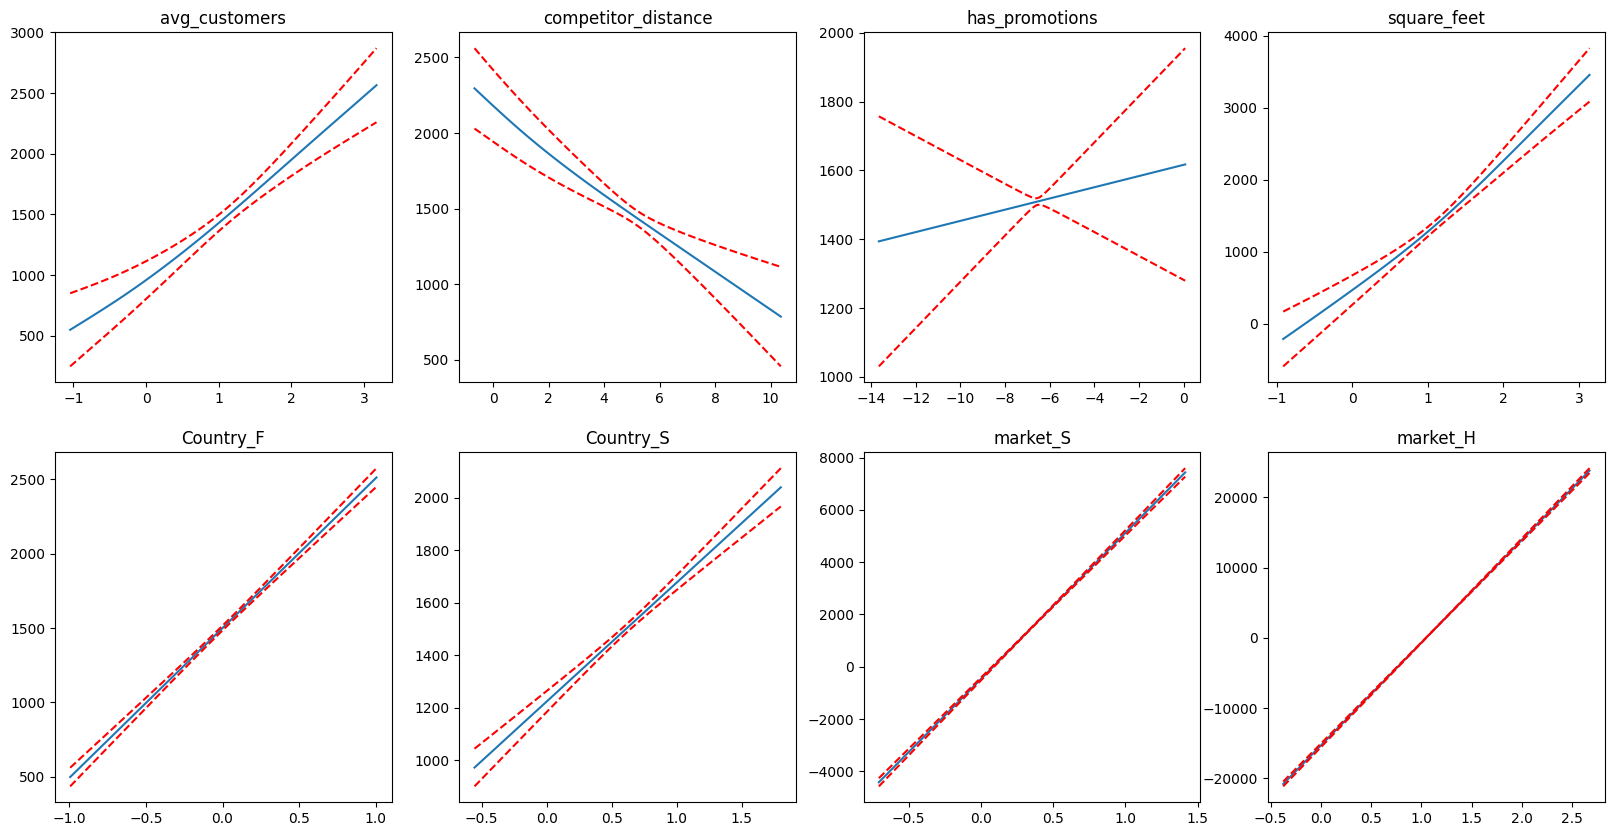

In [84]:
plt.figure()
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axs = axs.flatten()

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(best_features[i])

We can interpret the steepness of the splines as the intensity of the effect of the plotted predictor on the target variable, their downward or upward as a reference to the sign effect, and their smooothness related to the linearity of their relationships.
Hence we can state the following:
- **country_F**, **country_S**, **market_S**, **market_S**, **square_feet** and **average_customer** are all linear, positive and quite effective
- **competitor_distance** is quite linear and effective too, but it has a negative sign
- **has_promotions** has a quite weak effect, difficult to interpret effect because of the large confidence intervals


### Decision trees

*Decision Trees* provide a different approach from the previous ones. It is based on the idea of segmenting the predictor space into regions and then applying some statistics on the response to predict new value falling in a specific region.   
We first start with a standard decision tree with pruning (using cost complexity function) and then we'll move to the more powerful ensamble methods

In [85]:
# Trees
methods.append('Tree')

# initialize MSE and alpha
best_alpha = {"MSE": float("inf"), "alpha": float("inf")}

# fit a decision tree with all data to derive the alpha values (for tree pruning)
tree = DecisionTreeRegressor(random_state=55)
tree.fit(X_scaled, y)

# get alpha values
alphas = []
for node in tree.cost_complexity_pruning_path(X_scaled, y).impurities:
    alphas.append(max(0, node))
    
# test different values of alpha (control tree complexity)
for alpha in alphas:

    # Initialize an array to store MSE values for each fold
    mse_folds = []

    # run k-fold cv
    for train_idx, validation_idx in kf.split(X_scaled):
        X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
        y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

        # fit pruned tree
        pruned_tree = DecisionTreeRegressor(ccp_alpha=alpha, random_state=55)
        pruned_tree.fit(X_train, y_train)

        # get predictions
        y_pred = pruned_tree.predict(X_validation)
        current_mse = ((y_validation - y_pred)**2).mean()
        mse_folds.append(current_mse)
    
    # Calculate the mean MSE across folds
    estimated_test_error = sum(mse_folds) / len(mse_folds)

    # check if the estimated_test_error has decreased
    if estimated_test_error < best_alpha["MSE"]:
        best_alpha["MSE"] = estimated_test_error
        best_alpha["alpha"] = alpha

mses.append(best_alpha["MSE"])
print(f"The lowest estimated test error MSE is {round(best_alpha['MSE'], 2)}, obtained when alpha = {round(best_alpha['alpha'], 2)}")

# Train the final decision tree with the best alpha value and evaluate it on the test data
final_tree = DecisionTreeRegressor(ccp_alpha=best_alpha['alpha'], random_state=55)
final_tree.fit(X_scaled, y)


The lowest estimated test error MSE is 74236.3, obtained when alpha = 0.6


DecisionTreeRegressor(ccp_alpha=0.5964444450139998, random_state=55)

With this tree we obtain a surprisingly good result, which is usually unusual. But even in this case the result should be predicted: the $\alpha$ parameter, regolating the complexity of the model, is trained outside the kfold loop, hence it used all the observation at disposal, making this tree a 'cheating one'.

### Random Forest

*Random forest* belongs to the family of *Ensamble Methods*, based on the idea of building multiple "simple trees" and then combining all together to derive a powerful model, whose main goal is to reduce the variance. It also provides an alternative approach to *Bagging* with the goal of reducing the correlation among trees.  
Moreover, random forests consist of a collection of decision trees, each built on a bootstrapped training data and a random subset of the features at each split. In particular, we are going to use sqrt(n_features) as random subset at each split

In [86]:
# Random Forest
methods.append('Random Forest')

# Initialize an array to store MSE values for each fold
mse_folds = []

# run k-fold cv
for train_idx, validation_idx in kf.split(X_scaled):
    X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
    y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

    # create a Random Forest 
    model = RandomForestRegressor(n_estimators=1000, max_features="sqrt",max_depth=1000, random_state=55)

    # fit the model to the training data
    model.fit(X_train, y_train)

    # make predictions 
    y_pred = model.predict(X_validation)
    current_mse = ((y_validation - y_pred)**2).mean()
    mse_folds.append(current_mse)

   
# Calculate the mean MSE across folds
estimated_test_error = sum(mse_folds) / len(mse_folds)
mses.append(estimated_test_error )
print(f"The estimated test MSE error is {round(estimated_test_error, 2)}")

The estimated test MSE error is 175925.09


### Gradient Boosting

Now we are going to try *Gradient Boosting*, that also belongs to the family of *Ensamble methods*

In [87]:
# Gradient Boosting
methods.append('Gradient Boosting')

# Initialize an array to store MSE values for each fold
mse_folds = []

# run k-fold cv
for train_idx, validation_idx in kf.split(X_scaled):
    X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
    y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

    # create a Random Forest 
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=55)

    # fit the model to the training data
    model.fit(X_train, y_train)

    # make predictions 
    y_pred = model.predict(X_validation)
    current_mse = ((y_validation - y_pred)**2).mean()
    mse_folds.append(current_mse)

   
# Calculate the mean MSE across folds
estimated_test_error = sum(mse_folds) / len(mse_folds)
mses.append(estimated_test_error)
print(f"The estimated test MSE error is {round(estimated_test_error, 2)}")

The estimated test MSE error is 23778.08


### Support Vector Machine

*Support Vector Machine* is based on the concepts of *maximal margin classifier* and *support vector classifier*. It is a support vector classifier that uses transformations to enlarge the feature space

In [88]:
# Support Vector Machines
methods.append('SVM')

# find best parameters
parameters = {
    'C': np.linspace(1, 1000, 10).tolist(),  
    'kernel': ['rbf','linear'], 
    'gamma': ['scale', 'auto'] + np.linspace(0.01, 1, 10).tolist(), 
}

# Create the SVM model
svm = SVR()

# Create the GridSearchCV
grid_search = GridSearchCV(svm, parameters, cv=5)  

# Fit the GridSearchCV to the training data
grid_search.fit(X_scaled, y)

# Get the best parameters and the best score
best_params = grid_search.best_params_

print(best_params)

{'C': 556.0, 'gamma': 'scale', 'kernel': 'linear'}


In [89]:

mse_folds = []

# run k-fold cv
for train_idx, validation_idx in kf.split(X_scaled):
    X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
    y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

    # fit model
    model = SVR(C=best_params["C"], kernel=best_params["kernel"], gamma=best_params["gamma"]) 
    model.fit(X_train, y_train)

    # get predictions
    y_pred = model.predict(X_validation)
    current_mse = ((y_validation - y_pred)**2).mean()
    mse_folds.append(current_mse)

# Calculate the mean MSE across folds
estimated_test_error = sum(mse_folds) / len(mse_folds)
mses.append(estimated_test_error)
print(f"The estimated test MSE error is {round(estimated_test_error, 2)}")

The estimated test MSE error is 473700.33


### Neural Networks

*Neural Networks* are very powerful models, able to aproximate any function. Since they are really complicated, we exploit the package *pytorch*

In [90]:
#saving an auxiliary copy of our dataset
X2=X[best_features]

In [92]:
#NN
methods.append('NN')

# define NN architecture
def create_model(input_size, hidden_sizes, output_size):
    layers = []
    for i in range(len(hidden_sizes)):
        if i == 0:
            layers.append(nn.Linear(input_size, hidden_sizes[i]))
        else:
            layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
        layers.append(nn.ReLU())
    layers.append(nn.Linear(hidden_sizes[-1], output_size))
    return nn.Sequential(*layers)

X = scaler.fit_transform( X[best_features])
y = y.to_numpy().reshape(-1, 1)

# define the parameters 
input_size = X_train.shape[1]
hidden_sizes = [125,125]
output_size = 1
learning_rate = 1e-8
num_epochs = 3000
batch_size = 5

# Initialize an array to store MSE values for each fold
mse_folds = []

# run k-fold cv
for train_idx, validation_idx in kf.split(X):
    X_train, X_val = X[train_idx], X[validation_idx]
    y_train, y_val = y[train_idx], y[validation_idx]

    
    torch.manual_seed(55)

    # convert the numpy arrays to pytorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.FloatTensor(y_val) 

    # call the model
    model = create_model(input_size, hidden_sizes, output_size)

    # define the loss function: MSE
    criterion = nn.MSELoss()

    # optimizer: in pytorch "gradient descent" is called SDG (stochastic gradient descent)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # for each epoch, do forward and backward
    for epoch in range(num_epochs):
        for start in range(0, X_train_tensor.size(0), batch_size):
            # get batch
            X_batch = X_train_tensor[start: start+batch_size]
            y_batch = y_train_tensor[start: start+batch_size]
            #print(y_batch)

            # forward pass
            outputs = model.forward(X_batch)
            #print(outputs-y_batch)
            loss = criterion(outputs,y_batch)

            # backward pass and optimization (gradient descent)
            optimizer.zero_grad()  # reset gradient otherwise pytorch will use values from the previous iteration
            loss.backward() 
            optimizer.step()

        # print the loss at every 10 epochs
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}')

    # evaluate the model on the validation set
    with torch.no_grad():
        model.eval()
        y_pred = model.forward(X_val_tensor)
        valid_loss = criterion(y_pred, y_val_tensor)
        mse_folds.append(valid_loss.item())
        #print(f'The estimated test MSE is: {valid_loss.item()}')
estimated_test_error = sum(mse_folds) / len(mse_folds)
mses.append(estimated_test_error)
print(f"The estimated test MSE error is {round(estimated_test_error, 2)}")

Epoch [100/3000], Training Loss: 52287.7305
Epoch [200/3000], Training Loss: 24355.8027
Epoch [300/3000], Training Loss: 17647.7266
Epoch [400/3000], Training Loss: 13939.2812
Epoch [500/3000], Training Loss: 11519.4111
Epoch [600/3000], Training Loss: 9744.3223
Epoch [700/3000], Training Loss: 8558.1074
Epoch [800/3000], Training Loss: 7433.7046
Epoch [900/3000], Training Loss: 6614.8188
Epoch [1000/3000], Training Loss: 5942.4102
Epoch [1100/3000], Training Loss: 5386.7642
Epoch [1200/3000], Training Loss: 4956.1533
Epoch [1300/3000], Training Loss: 4607.6548
Epoch [1400/3000], Training Loss: 4296.5049
Epoch [1500/3000], Training Loss: 4046.4812
Epoch [1600/3000], Training Loss: 3823.8765
Epoch [1700/3000], Training Loss: 3636.0671
Epoch [1800/3000], Training Loss: 3475.7446
Epoch [1900/3000], Training Loss: 3350.1433
Epoch [2000/3000], Training Loss: 3278.5249
Epoch [2100/3000], Training Loss: 3208.9314
Epoch [2200/3000], Training Loss: 3134.8257
Epoch [2300/3000], Training Loss: 30

Our results are

In [93]:
results=pd.DataFrame({
    'methods':methods,
    'mses':mses
})
results

,methods,mses
0,Poly 2,1.242103e+24
1,Poly 3,1.638398e+26
2,GAM,3.874554e+05
3,Tree,7.423630e+04
4,Random Forest,1.759251e+05
5,Gradient Boosting,2.377808e+04
6,SVM,4.737003e+05
7,NN,6.152715e+03


After having computed all the models and compared the results, we obtain that the best one is Neural Networks with kfold and parameters: hidden sizes = [125,125], output_size = 1, learning_rate = 1e-8, num_epochs = 3000 and batch_size = 5 

In [94]:
print(f'The best methodology is {methods[np.argmin(mses)]} with a MSE of {round(min(mses),3)}')

The best methodology is NN with a MSE of 6152.715


In [95]:
#defining the dataset for the three choice we have to made
mkt_to_choose_mini = pd.DataFrame({'avg_customers':[190,215,220],'competitor_distance':[4500,1850,1450],'has_promotions':[1,1,1],'square_feet':[1850,2100,1920],'Country_F':[0,1,0],'Country_S':[1,0,0],'market_S':[0,0,0],'market_H':[0,0,0]})
mkt_to_choose_super = pd.DataFrame({'avg_customers':[420,390,410],'competitor_distance':[580,2560,3520],'has_promotions':[1,1,1],'square_feet':[5880,5120,4970],'Country_F':[0,1,0],'Country_S':[1,0,0],'market_S':[1,1,1],'market_H':[0,0,0]})
mkt_to_choose_hyper = pd.DataFrame({'avg_customers':[860,880,790],'competitor_distance':[8940,7580,11560],'has_promotions':[1,1,1],'square_feet':[10560,12570,11980],'Country_F':[0,1,0],'Country_S':[1,0,0],'market_S':[0,0,0],'market_H':[1,1,1]})

#standardizing the three dataset through the auxiliary dataset
X2=pd.concat([X2, mkt_to_choose_mini, mkt_to_choose_super, mkt_to_choose_hyper],ignore_index=True)
X2 = scaler.fit_transform(X2)
mkt_to_choose_mini=torch.FloatTensor(X2[750:753,:])
mkt_to_choose_super=torch.FloatTensor(X2[753:756,:])
mkt_to_choose_hyper=torch.FloatTensor(X2[756:759,:])

#predicting them with NN
with torch.no_grad():
    model.eval()
    y_pred_hyper = model.forward(mkt_to_choose_hyper)
    y_pred_super =  model.forward(mkt_to_choose_super)
    y_pred_mini =  model.forward(mkt_to_choose_mini)

mkt_types_to_choose=['Spain','France','Italy']
print(f'Regarding the markets of type MINI the company would do best if opening the one in {mkt_types_to_choose[np.argmax(y_pred_mini)]}')
print(f'Regarding the markets of type SUPER the company would do best if opening the one in {mkt_types_to_choose[np.argmax(y_pred_super)]}')
print(f'Regarding the markets of type HYPER the company would do best if opening the one in {mkt_types_to_choose[np.argmax(y_pred_hyper)]}')




Regarding the markets of type MINI the company would do best if opening the one in France
Regarding the markets of type SUPER the company would do best if opening the one in France
Regarding the markets of type HYPER the company would do best if opening the one in France


Applying it to the data of interest, we predict that, given the options, thebest market to open is in France, for each type of market.

**Note**: comparing all the MSE obtained, we recognize that the one corresponding to Polynomial Regression is extremely high. We suppose that probably we made a mistake in cleaning step, in particular during the Nan values filling. However, the results obtained using all the other models seem to us good and attainable